In [1]:
# ============================================================
# Cell 1: Install required packages
# Run this cell only once per Colab session.
# ============================================================

!pip install SimpleITK numpy matplotlib scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.0 MB/s eta 0:00:00


In [2]:
# ============================================================
# Cell 2: Import libraries
# ============================================================

import os
from glob import glob

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import ndimage


In [3]:
# ============================================================
# Cell 3: Mount Google Drive
# You must grant permission when running this cell.
# ============================================================

from google.colab import drive

drive.mount('/content/drive')  # Follow the link and paste the auth code


Mounted at /content/drive


In [4]:
# ============================================================
# Cell 4: Define data paths (EDIT THESE PATHS FOR YOUR DRIVE)
# ============================================================

# Root folder of your LOLA11 data
DATA_ROOT = '/content/drive/MyDrive/LOLA11'

# All images are directly under DATA_ROOT (no 'images/' folder)
IMAGE_DIR = DATA_ROOT

# If your labels are also in the same folder, use this:
LABEL_DIR = DATA_ROOT

# Folder to save results
RESULT_DIR = os.path.join(DATA_ROOT, 'results')
os.makedirs(RESULT_DIR, exist_ok=True)

print("IMAGE_DIR:", IMAGE_DIR)
print("LABEL_DIR:", LABEL_DIR)
print("RESULT_DIR:", RESULT_DIR)

# Now list mha files
image_paths = sorted(glob(os.path.join(IMAGE_DIR, '*.mha')))
print(f"Found {len(image_paths)} CT volumes.")


IMAGE_DIR: /content/drive/MyDrive/LOLA11
LABEL_DIR: /content/drive/MyDrive/LOLA11
RESULT_DIR: /content/drive/MyDrive/LOLA11/results
Found 55 CT volumes.


In [5]:
# ================================================
# Cell 5 : Install lungmask
# ================================================
!pip install lungmask


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 117.9 MB/s eta 0:00:00


In [6]:
# ================================================
# Cell 6 : Set up lungmask inferer with GPU/CPU auto selection
# ================================================
import torch
from lungmask import LMInferer, utils

# Check whether a GPU is available in this Colab runtime
use_gpu = torch.cuda.is_available()
if use_gpu:
    device_name = torch.cuda.get_device_name(0)
    print(f"CUDA available: True (GPU: {device_name})")
    force_cpu = False          # allow lungmask to use the GPU
    batch_size = 20            # you can tune this if you hit OOM
else:
    print("CUDA available: False. Using CPU only.")
    force_cpu = True           # force CPU mode
    batch_size = 1             # safer on CPU, but slower

# This reproduces the "LTRCLobes_R231" mode:
#   - main model: LTRCLobes (lobe segmentation)
#   - fill model: R231 (ensure full lung coverage)
inferer = LMInferer(
    modelname="LTRCLobes",
    fillmodel="R231",
    force_cpu=force_cpu,
    batch_size=batch_size,
    volume_postprocessing=True,
    tqdm_disable=False,
)

print("Inferer ready.")
print(f"force_cpu = {force_cpu}, batch_size = {batch_size}")


CUDA available: True (GPU: Tesla T4)
Downloading: "https://github.com/JoHof/lungmask/releases/download/v0.0/unet_ltrclobes-3a07043d.pth" to /root/.cache/torch/hub/checkpoints/unet_ltrclobes-3a07043d.pth


100%|██████████| 119M/119M [00:03<00:00, 39.8MB/s]


Downloading: "https://github.com/JoHof/lungmask/releases/download/v0.0/unet_r231-d5d2fc3d.pth" to /root/.cache/torch/hub/checkpoints/unet_r231-d5d2fc3d.pth


100%|██████████| 119M/119M [00:01<00:00, 107MB/s]


Inferer ready.
force_cpu = False, batch_size = 20


In [7]:
# ================================================
# Cell 7 : Run lungmask on one volume (with downsampling)
# ================================================

def run_lungmask_on_volume(image_path, result_dir,
                           use_downsample=True,
                           target_spacing=(2.0, 2.0, 2.0)):
    """
    Load a 3D CT volume, optionally downsample it for faster inference,
    run the LTRCLobes+R231 lungmask model, resample the predicted mask
    back to the original resolution, save it, and return useful objects.

    Parameters
    ----------
    image_path : str
        Path to the input .mha CT volume.
    result_dir : str
        Directory where the output mask will be saved.
    use_downsample : bool
        If True, resample the CT to target_spacing before inference.
    target_spacing : tuple of float
        (sx, sy, sz) in mm for the downsampled CT.

    Returns
    -------
    out_path : str
        Path to the saved segmentation mask (.mha).
    img_orig : sitk.Image
        Original CT image (full resolution).
    img_arr_orig : np.ndarray
        Original CT as numpy array (z, y, x).
    mask_arr_full : np.ndarray
        Predicted mask on the original grid (z, y, x).
    """
    # 1. Read original CT image
    img_orig = sitk.ReadImage(image_path)
    orig_spacing = img_orig.GetSpacing()   # (sx, sy, sz)
    orig_size = img_orig.GetSize()        # (nx, ny, nz)

    print("Original spacing:", orig_spacing)
    print("Original size   :", orig_size)

    # 2. Optionally downsample for faster inference
    if use_downsample:
        # Compute new size based on target spacing
        new_size = [
            int(round(orig_size[i] * (orig_spacing[i] / target_spacing[i])))
            for i in range(3)
        ]

        print("Downsampled spacing:", target_spacing)
        print("Downsampled size   :", new_size)

        resampler = sitk.ResampleImageFilter()
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetOutputSpacing(target_spacing)
        resampler.SetSize(new_size)
        resampler.SetOutputDirection(img_orig.GetDirection())
        resampler.SetOutputOrigin(img_orig.GetOrigin())
        resampler.SetOutputPixelType(img_orig.GetPixelID())

        img_for_inference = resampler.Execute(img_orig)
    else:
        # Use original resolution directly (slower)
        img_for_inference = img_orig

    # 3. Run lungmask on the (possibly downsampled) image
    img_ds_arr = sitk.GetArrayFromImage(img_for_inference)
    print("Inference input shape (z, y, x):", img_ds_arr.shape)

    mask_ds_arr = inferer.apply(img_for_inference)  # numpy (z, y, x)

    # 4. Convert downsampled mask to SimpleITK image
    mask_ds_img = sitk.GetImageFromArray(mask_ds_arr.astype(np.int16))
    mask_ds_img.CopyInformation(img_for_inference)

    # 5. Resample mask back to original grid
    upsampler = sitk.ResampleImageFilter()
    upsampler.SetReferenceImage(img_orig)
    upsampler.SetInterpolator(sitk.sitkNearestNeighbor)  # preserve labels
    mask_full_img = upsampler.Execute(mask_ds_img)

    mask_arr_full = sitk.GetArrayFromImage(mask_full_img)
    img_arr_orig = sitk.GetArrayFromImage(img_orig)

    print("Final mask shape (z, y, x):", mask_arr_full.shape)

    # 6. Build output filename
    base = os.path.basename(image_path)
    if base.endswith(".mha"):
        out_name = base.replace(".mha", "_lungmask_lobes.mha")
    else:
        out_name = base + "_lungmask_lobes.mha"

    out_path = os.path.join(result_dir, out_name)

    # 7. Save the full-resolution mask
    sitk.WriteImage(mask_full_img, out_path)
    print(f"Saved segmentation to: {out_path}")

    return out_path, img_orig, img_arr_orig, mask_arr_full


In [8]:
# ================================================
# Cell 8 : Visualization helper (single axial slice)
# ================================================

def show_mid_slice_with_mask(img_arr, mask_arr, slice_index=None):
    """
    Display a CT slice and its corresponding lobe segmentation overlay.

    img_arr: numpy array of original CT (z, y, x)
    mask_arr: numpy array of predicted labels (z, y, x)
    slice_index: which slice to show; if None, show the middle slice
    """
    if slice_index is None:
        slice_index = img_arr.shape[0] // 2  # middle slice

    ct_slice = img_arr[slice_index]
    mask_slice = mask_arr[slice_index]

    plt.figure(figsize=(10, 4))

    # Left: original CT slice
    plt.subplot(1, 2, 1)
    plt.title(f"CT slice {slice_index}")
    plt.imshow(ct_slice, cmap="gray")
    plt.axis("off")

    # Right: CT + overlay mask
    plt.subplot(1, 2, 2)
    plt.title("Lobe segmentation overlay")
    plt.imshow(ct_slice, cmap="gray")
    plt.imshow(mask_slice, alpha=0.5)  # overlay using label colors
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [9]:
# ================================================
# Cell 9 : Run lungmask on the volumes (with resume)
# ================================================
from tqdm.auto import tqdm

def get_output_path(image_path, result_dir):
    """
    Build the expected output path for a given input CT.
    This must match the logic inside run_lungmask_on_volume.
    """
    base = os.path.basename(image_path)
    if base.endswith(".mha"):
        out_name = base.replace(".mha", "_lungmask_lobes.mha")
    else:
        out_name = base + "_lungmask_lobes.mha"
    return os.path.join(result_dir, out_name)

all_results = []
num_skipped = 0
num_processed = 0

# Process all cases
to_process = image_paths  #run all 55 cases

for path in tqdm(to_process, desc="Running lungmask on first 5 cases"):
    out_path = get_output_path(path, RESULT_DIR)

    # Resume logic: skip if the output file already exists
    if os.path.exists(out_path):
        num_skipped += 1
        continue

    try:
        print("=" * 60)
        print("Processing:", path)
        out_path, img, img_arr, mask_arr = run_lungmask_on_volume(
            path,
            RESULT_DIR,
            use_downsample=True,            # set False if you want full-res
            target_spacing=(2.0, 2.0, 2.0)  # you can tweak this
        )
        all_results.append((path, out_path))
        num_processed += 1

        # Optional: quick visual check for this case
        # show_mid_slice_with_mask(img_arr, mask_arr)

    except Exception as e:
        print(f"Error while processing {path}: {e}")

print(f"Done. New cases processed: {num_processed}, skipped (already done): {num_skipped}")


Running lungmask on first 5 cases:   0%|          | 0/55 [00:00<?, ?it/s]

Processing: /content/drive/MyDrive/LOLA11/lola11-06.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 322)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 161]
Inference input shape (z, y, x): (161, 175, 175)
lungmask 2025-11-27 16:11:36 Apply: LTRCLobes



  0%|          | 0/8.05 [00:00<?, ?it/s]
 12%|█▏        | 1/8.05 [00:01<00:08,  1.22s/it]
 25%|██▍       | 2/8.05 [00:01<00:04,  1.38it/s]
 37%|███▋      | 3/8.05 [00:01<00:02,  1.76it/s]
 50%|████▉     | 4/8.05 [00:02<00:02,  2.02it/s]
 62%|██████▏   | 5/8.05 [00:02<00:01,  2.21it/s]
 75%|███████▍  | 6/8.05 [00:03<00:00,  2.33it/s]
 87%|████████▋ | 7/8.05 [00:03<00:00,  2.42it/s]
9it [00:03,  2.29it/s]                          

lungmask 2025-11-27 16:11:41 Postprocessing




100%|██████████| 121/121 [00:01<00:00, 70.67it/s]


lungmask 2025-11-27 16:11:45 Apply: R231



  0%|          | 0/8.05 [00:00<?, ?it/s]
 12%|█▏        | 1/8.05 [00:00<00:03,  2.33it/s]
 25%|██▍       | 2/8.05 [00:00<00:02,  2.49it/s]
 37%|███▋      | 3/8.05 [00:01<00:01,  2.58it/s]
 50%|████▉     | 4/8.05 [00:01<00:01,  2.60it/s]
 62%|██████▏   | 5/8.05 [00:01<00:01,  2.62it/s]
 75%|███████▍  | 6/8.05 [00:02<00:00,  2.62it/s]
 87%|████████▋ | 7/8.05 [00:02<00:00,  2.62it/s]
9it [00:03,  2.89it/s]                          

lungmask 2025-11-27 16:11:49 Postprocessing




100%|██████████| 6/6 [00:00<00:00, 218.94it/s]


lungmask 2025-11-27 16:11:51 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:11:51 Postprocessing



100%|██████████| 1209/1209 [00:01<00:00, 661.40it/s]  


Final mask shape (z, y, x): (322, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-06_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-07.mha
Original spacing: (0.5507810115814209, 0.5507810115814209, 0.2999880015850067)
Original size   : (512, 512, 971)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [141, 141, 146]
Inference input shape (z, y, x): (146, 141, 141)
lungmask 2025-11-27 16:12:05 Apply: LTRCLobes



  0%|          | 0/7.3 [00:00<?, ?it/s]
 14%|█▎        | 1/7.3 [00:00<00:02,  2.27it/s]
 27%|██▋       | 2/7.3 [00:00<00:02,  2.48it/s]
 41%|████      | 3/7.3 [00:01<00:01,  2.55it/s]
 55%|█████▍    | 4/7.3 [00:01<00:01,  2.57it/s]
 68%|██████▊   | 5/7.3 [00:01<00:00,  2.59it/s]
 82%|████████▏ | 6/7.3 [00:02<00:00,  2.60it/s]
 96%|█████████▌| 7/7.3 [00:02<00:00,  2.61it/s]
8it [00:02,  2.81it/s]

lungmask 2025-11-27 16:12:09 Postprocessing




100%|██████████| 437/437 [00:08<00:00, 53.75it/s]


lungmask 2025-11-27 16:12:19 Apply: R231



  0%|          | 0/7.3 [00:00<?, ?it/s]
 14%|█▎        | 1/7.3 [00:00<00:02,  2.28it/s]
 27%|██▋       | 2/7.3 [00:00<00:02,  2.48it/s]
 41%|████      | 3/7.3 [00:01<00:01,  2.54it/s]
 55%|█████▍    | 4/7.3 [00:01<00:01,  2.58it/s]
 68%|██████▊   | 5/7.3 [00:01<00:00,  2.59it/s]
 82%|████████▏ | 6/7.3 [00:02<00:00,  2.61it/s]
 96%|█████████▌| 7/7.3 [00:02<00:00,  2.61it/s]
8it [00:02,  2.81it/s]

lungmask 2025-11-27 16:12:23 Postprocessing




100%|██████████| 60/60 [00:00<00:00, 75.94it/s]


lungmask 2025-11-27 16:12:25 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:12:25 Postprocessing



100%|██████████| 1262/1262 [00:01<00:00, 1051.93it/s] 


Final mask shape (z, y, x): (971, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-07_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-08.mha
Original spacing: (0.703125, 0.703125, 0.6000000238418579)
Original size   : (512, 512, 601)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [180, 180, 180]
Inference input shape (z, y, x): (180, 180, 180)
lungmask 2025-11-27 16:12:38 Apply: LTRCLobes



  0%|          | 0/9.0 [00:00<?, ?it/s]
 11%|█         | 1/9.0 [00:00<00:03,  2.25it/s]
 22%|██▏       | 2/9.0 [00:00<00:02,  2.48it/s]
 33%|███▎      | 3/9.0 [00:01<00:02,  2.54it/s]
 44%|████▍     | 4/9.0 [00:01<00:01,  2.56it/s]
 56%|█████▌    | 5/9.0 [00:01<00:01,  2.57it/s]
 67%|██████▋   | 6/9.0 [00:02<00:01,  2.59it/s]
 78%|███████▊  | 7/9.0 [00:02<00:00,  2.57it/s]
 89%|████████▉ | 8/9.0 [00:03<00:00,  2.55it/s]
100%|██████████| 9/9.0 [00:03<00:00,  2.54it/s]

lungmask 2025-11-27 16:12:43 Postprocessing




100%|██████████| 78/78 [00:01<00:00, 39.64it/s]


lungmask 2025-11-27 16:12:48 Apply: R231



  0%|          | 0/9.0 [00:00<?, ?it/s]
 11%|█         | 1/9.0 [00:00<00:03,  2.16it/s]
 22%|██▏       | 2/9.0 [00:00<00:02,  2.43it/s]
 33%|███▎      | 3/9.0 [00:01<00:02,  2.52it/s]
 44%|████▍     | 4/9.0 [00:01<00:01,  2.56it/s]
 56%|█████▌    | 5/9.0 [00:01<00:01,  2.58it/s]
 67%|██████▋   | 6/9.0 [00:02<00:01,  2.60it/s]
 78%|███████▊  | 7/9.0 [00:02<00:00,  2.61it/s]
 89%|████████▉ | 8/9.0 [00:03<00:00,  2.61it/s]
100%|██████████| 9/9.0 [00:03<00:00,  2.56it/s]

lungmask 2025-11-27 16:12:53 Postprocessing




100%|██████████| 9/9 [00:00<00:00, 79.78it/s]


lungmask 2025-11-27 16:12:55 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:12:55 Postprocessing



100%|██████████| 1694/1694 [00:03<00:00, 499.48it/s]  


Final mask shape (z, y, x): (601, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-08_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-09.mha
Original spacing: (0.78125, 0.78125, 0.800000011920929)
Original size   : (512, 512, 451)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [200, 200, 180]
Inference input shape (z, y, x): (180, 200, 200)
lungmask 2025-11-27 16:13:10 Apply: LTRCLobes



  0%|          | 0/9.0 [00:00<?, ?it/s]
 11%|█         | 1/9.0 [00:00<00:03,  2.10it/s]
 22%|██▏       | 2/9.0 [00:00<00:02,  2.40it/s]
 33%|███▎      | 3/9.0 [00:01<00:02,  2.50it/s]
 44%|████▍     | 4/9.0 [00:01<00:01,  2.53it/s]
 56%|█████▌    | 5/9.0 [00:02<00:01,  2.56it/s]
 67%|██████▋   | 6/9.0 [00:02<00:01,  2.57it/s]
 78%|███████▊  | 7/9.0 [00:02<00:00,  2.57it/s]
 89%|████████▉ | 8/9.0 [00:03<00:00,  2.58it/s]
100%|██████████| 9/9.0 [00:03<00:00,  2.53it/s]

lungmask 2025-11-27 16:13:15 Postprocessing




100%|██████████| 66/66 [00:01<00:00, 57.05it/s]


lungmask 2025-11-27 16:13:19 Apply: R231



  0%|          | 0/9.0 [00:00<?, ?it/s]
 11%|█         | 1/9.0 [00:00<00:03,  2.17it/s]
 22%|██▏       | 2/9.0 [00:00<00:02,  2.40it/s]
 33%|███▎      | 3/9.0 [00:01<00:02,  2.51it/s]
 44%|████▍     | 4/9.0 [00:01<00:01,  2.55it/s]
 56%|█████▌    | 5/9.0 [00:01<00:01,  2.57it/s]
 67%|██████▋   | 6/9.0 [00:02<00:01,  2.58it/s]
 78%|███████▊  | 7/9.0 [00:02<00:00,  2.59it/s]
 89%|████████▉ | 8/9.0 [00:03<00:00,  2.59it/s]
100%|██████████| 9/9.0 [00:03<00:00,  2.55it/s]

lungmask 2025-11-27 16:13:23 Postprocessing




100%|██████████| 3/3 [00:00<00:00, 82.80it/s]


lungmask 2025-11-27 16:13:25 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:13:25 Postprocessing



100%|██████████| 1332/1332 [00:02<00:00, 479.84it/s]  


Final mask shape (z, y, x): (451, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-09_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-10.mha
Original spacing: (0.6367189884185791, 0.6367189884185791, 0.800000011920929)
Original size   : (512, 512, 428)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [163, 163, 171]
Inference input shape (z, y, x): (171, 163, 163)
lungmask 2025-11-27 16:13:37 Apply: LTRCLobes



  0%|          | 0/8.55 [00:00<?, ?it/s]
 12%|█▏        | 1/8.55 [00:00<00:03,  2.29it/s]
 23%|██▎       | 2/8.55 [00:00<00:02,  2.49it/s]
 35%|███▌      | 3/8.55 [00:01<00:02,  2.55it/s]
 47%|████▋     | 4/8.55 [00:01<00:01,  2.57it/s]
 58%|█████▊    | 5/8.55 [00:01<00:01,  2.59it/s]
 70%|███████   | 6/8.55 [00:02<00:00,  2.59it/s]
 82%|████████▏ | 7/8.55 [00:02<00:00,  2.59it/s]
 94%|█████████▎| 8/8.55 [00:03<00:00,  2.60it/s]
/usr/local/lib/python3.12/dist-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
105%|██████████| 9/8.55 [00:03<00:00,  2.69it/s]

lungmask 2025-11-27 16:13:41 Postprocessing




100%|██████████| 91/91 [00:01<00:00, 54.23it/s]


lungmask 2025-11-27 16:13:45 Apply: R231



  0%|          | 0/8.55 [00:00<?, ?it/s]
 12%|█▏        | 1/8.55 [00:00<00:03,  2.19it/s]
 23%|██▎       | 2/8.55 [00:00<00:02,  2.43it/s]
 35%|███▌      | 3/8.55 [00:01<00:02,  2.52it/s]
 47%|████▋     | 4/8.55 [00:01<00:01,  2.55it/s]
 58%|█████▊    | 5/8.55 [00:01<00:01,  2.57it/s]
 70%|███████   | 6/8.55 [00:02<00:00,  2.58it/s]
 82%|████████▏ | 7/8.55 [00:02<00:00,  2.59it/s]
 94%|█████████▎| 8/8.55 [00:03<00:00,  2.60it/s]
105%|██████████| 9/8.55 [00:03<00:00,  2.68it/s]

lungmask 2025-11-27 16:13:50 Postprocessing




100%|██████████| 3/3 [00:00<00:00, 92.51it/s]


lungmask 2025-11-27 16:13:51 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:13:51 Postprocessing



100%|██████████| 1289/1289 [00:01<00:00, 658.83it/s]  


Final mask shape (z, y, x): (428, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-10_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-11.mha
Original spacing: (0.5820310115814209, 0.5820310115814209, 0.7000049948692322)
Original size   : (512, 512, 390)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [149, 149, 137]
Inference input shape (z, y, x): (137, 149, 149)
lungmask 2025-11-27 16:14:02 Apply: LTRCLobes



  0%|          | 0/6.85 [00:00<?, ?it/s]
 15%|█▍        | 1/6.85 [00:00<00:02,  2.20it/s]
 29%|██▉       | 2/6.85 [00:00<00:01,  2.44it/s]
 44%|████▍     | 3/6.85 [00:01<00:01,  2.51it/s]
 58%|█████▊    | 4/6.85 [00:01<00:01,  2.54it/s]
 73%|███████▎  | 5/6.85 [00:01<00:00,  2.56it/s]
 88%|████████▊ | 6/6.85 [00:02<00:00,  2.58it/s]
102%|██████████| 7/6.85 [00:02<00:00,  2.57it/s]

lungmask 2025-11-27 16:14:05 Postprocessing




100%|██████████| 59/59 [00:00<00:00, 66.47it/s]


lungmask 2025-11-27 16:14:09 Apply: R231



  0%|          | 0/6.85 [00:00<?, ?it/s]
 15%|█▍        | 1/6.85 [00:00<00:02,  2.16it/s]
 29%|██▉       | 2/6.85 [00:00<00:02,  2.41it/s]
 44%|████▍     | 3/6.85 [00:01<00:01,  2.51it/s]
 58%|█████▊    | 4/6.85 [00:01<00:01,  2.55it/s]
 73%|███████▎  | 5/6.85 [00:01<00:00,  2.58it/s]
 88%|████████▊ | 6/6.85 [00:02<00:00,  2.59it/s]
102%|██████████| 7/6.85 [00:02<00:00,  2.57it/s]

lungmask 2025-11-27 16:14:12 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 179.92it/s]


lungmask 2025-11-27 16:14:14 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:14:14 Postprocessing



100%|██████████| 2431/2431 [00:03<00:00, 672.40it/s]  


Final mask shape (z, y, x): (390, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-11_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-12.mha
Original spacing: (0.6914060115814209, 0.6914060115814209, 0.8000029921531677)
Original size   : (512, 512, 459)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [177, 177, 184]
Inference input shape (z, y, x): (184, 177, 177)
lungmask 2025-11-27 16:14:26 Apply: LTRCLobes



  0%|          | 0/9.2 [00:00<?, ?it/s]
 11%|█         | 1/9.2 [00:00<00:03,  2.21it/s]
 22%|██▏       | 2/9.2 [00:00<00:02,  2.42it/s]
 33%|███▎      | 3/9.2 [00:01<00:02,  2.51it/s]
 43%|████▎     | 4/9.2 [00:01<00:02,  2.54it/s]
 54%|█████▍    | 5/9.2 [00:01<00:01,  2.57it/s]
 65%|██████▌   | 6/9.2 [00:02<00:01,  2.58it/s]
 76%|███████▌  | 7/9.2 [00:02<00:00,  2.59it/s]
 87%|████████▋ | 8/9.2 [00:03<00:00,  2.59it/s]
10it [00:03,  2.76it/s]                        

lungmask 2025-11-27 16:14:32 Postprocessing




100%|██████████| 97/97 [00:01<00:00, 57.96it/s]


lungmask 2025-11-27 16:14:36 Apply: R231



  0%|          | 0/9.2 [00:00<?, ?it/s]
 11%|█         | 1/9.2 [00:00<00:03,  2.13it/s]
 22%|██▏       | 2/9.2 [00:00<00:03,  2.37it/s]
 33%|███▎      | 3/9.2 [00:01<00:02,  2.47it/s]
 43%|████▎     | 4/9.2 [00:01<00:02,  2.52it/s]
 54%|█████▍    | 5/9.2 [00:02<00:01,  2.54it/s]
 65%|██████▌   | 6/9.2 [00:02<00:01,  2.56it/s]
 76%|███████▌  | 7/9.2 [00:02<00:00,  2.57it/s]
 87%|████████▋ | 8/9.2 [00:03<00:00,  2.57it/s]
10it [00:03,  2.74it/s]                        

lungmask 2025-11-27 16:14:41 Postprocessing




100%|██████████| 3/3 [00:00<00:00, 244.48it/s]


lungmask 2025-11-27 16:14:43 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:14:43 Postprocessing



100%|██████████| 1375/1375 [00:02<00:00, 596.16it/s]  


Final mask shape (z, y, x): (459, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-12_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-13.mha
Original spacing: (0.5351560115814209, 0.5351560115814209, 0.5)
Original size   : (512, 512, 642)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [137, 137, 160]
Inference input shape (z, y, x): (160, 137, 137)
lungmask 2025-11-27 16:14:56 Apply: LTRCLobes



  0%|          | 0/8.0 [00:00<?, ?it/s]
 12%|█▎        | 1/8.0 [00:00<00:03,  2.12it/s]
 25%|██▌       | 2/8.0 [00:00<00:02,  2.39it/s]
 38%|███▊      | 3/8.0 [00:01<00:02,  2.49it/s]
 50%|█████     | 4/8.0 [00:01<00:01,  2.53it/s]
 62%|██████▎   | 5/8.0 [00:02<00:01,  2.56it/s]
 75%|███████▌  | 6/8.0 [00:02<00:00,  2.57it/s]
 88%|████████▊ | 7/8.0 [00:02<00:00,  2.58it/s]
100%|██████████| 8/8.0 [00:03<00:00,  2.53it/s]

lungmask 2025-11-27 16:15:00 Postprocessing




100%|██████████| 160/160 [00:02<00:00, 59.48it/s]


lungmask 2025-11-27 16:15:06 Apply: R231



  0%|          | 0/8.0 [00:00<?, ?it/s]
 12%|█▎        | 1/8.0 [00:00<00:03,  2.21it/s]
 25%|██▌       | 2/8.0 [00:00<00:02,  2.43it/s]
 38%|███▊      | 3/8.0 [00:01<00:01,  2.51it/s]
 50%|█████     | 4/8.0 [00:01<00:01,  2.54it/s]
 62%|██████▎   | 5/8.0 [00:01<00:01,  2.56it/s]
 75%|███████▌  | 6/8.0 [00:02<00:00,  2.57it/s]
 88%|████████▊ | 7/8.0 [00:02<00:00,  2.58it/s]
100%|██████████| 8/8.0 [00:03<00:00,  2.54it/s]

lungmask 2025-11-27 16:15:11 Postprocessing




100%|██████████| 10/10 [00:00<00:00, 63.89it/s]


lungmask 2025-11-27 16:15:12 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:15:12 Postprocessing



100%|██████████| 1534/1534 [00:01<00:00, 1372.18it/s] 


Final mask shape (z, y, x): (642, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-13_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-14.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 286)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 143]
Inference input shape (z, y, x): (143, 175, 175)
lungmask 2025-11-27 16:15:21 Apply: LTRCLobes



  0%|          | 0/7.15 [00:00<?, ?it/s]
 14%|█▍        | 1/7.15 [00:00<00:02,  2.11it/s]
 28%|██▊       | 2/7.15 [00:00<00:02,  2.39it/s]
 42%|████▏     | 3/7.15 [00:01<00:01,  2.49it/s]
 56%|█████▌    | 4/7.15 [00:01<00:01,  2.53it/s]
 70%|██████▉   | 5/7.15 [00:02<00:00,  2.56it/s]
 84%|████████▍ | 6/7.15 [00:02<00:00,  2.57it/s]
8it [00:02,  2.82it/s]                          

lungmask 2025-11-27 16:15:25 Postprocessing




100%|██████████| 94/94 [00:01<00:00, 67.67it/s]


lungmask 2025-11-27 16:15:29 Apply: R231



  0%|          | 0/7.15 [00:00<?, ?it/s]
 14%|█▍        | 1/7.15 [00:00<00:02,  2.23it/s]
 28%|██▊       | 2/7.15 [00:00<00:02,  2.45it/s]
 42%|████▏     | 3/7.15 [00:01<00:01,  2.52it/s]
 56%|█████▌    | 4/7.15 [00:01<00:01,  2.54it/s]
 70%|██████▉   | 5/7.15 [00:01<00:00,  2.56it/s]
 84%|████████▍ | 6/7.15 [00:02<00:00,  2.57it/s]
8it [00:02,  2.84it/s]                          

lungmask 2025-11-27 16:15:33 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 287.20it/s]


lungmask 2025-11-27 16:15:35 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:15:35 Postprocessing



100%|██████████| 1145/1145 [00:01<00:00, 860.79it/s] 


Final mask shape (z, y, x): (286, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-14_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-15.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 338)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 169]
Inference input shape (z, y, x): (169, 175, 175)
lungmask 2025-11-27 16:15:42 Apply: LTRCLobes



  0%|          | 0/8.45 [00:00<?, ?it/s]
 12%|█▏        | 1/8.45 [00:00<00:03,  2.24it/s]
 24%|██▎       | 2/8.45 [00:00<00:02,  2.44it/s]
 36%|███▌      | 3/8.45 [00:01<00:02,  2.50it/s]
 47%|████▋     | 4/8.45 [00:01<00:01,  2.53it/s]
 59%|█████▉    | 5/8.45 [00:01<00:01,  2.55it/s]
 71%|███████   | 6/8.45 [00:02<00:00,  2.56it/s]
 83%|████████▎ | 7/8.45 [00:02<00:00,  2.57it/s]
 95%|█████████▍| 8/8.45 [00:03<00:00,  2.58it/s]
9it [00:03,  2.71it/s]

lungmask 2025-11-27 16:15:47 Postprocessing




100%|██████████| 108/108 [00:02<00:00, 52.01it/s]


lungmask 2025-11-27 16:15:52 Apply: R231



  0%|          | 0/8.45 [00:00<?, ?it/s]
 12%|█▏        | 1/8.45 [00:00<00:03,  2.12it/s]
 24%|██▎       | 2/8.45 [00:00<00:02,  2.40it/s]
 36%|███▌      | 3/8.45 [00:01<00:02,  2.49it/s]
 47%|████▋     | 4/8.45 [00:01<00:01,  2.53it/s]
 59%|█████▉    | 5/8.45 [00:02<00:01,  2.55it/s]
 71%|███████   | 6/8.45 [00:02<00:00,  2.57it/s]
 83%|████████▎ | 7/8.45 [00:02<00:00,  2.58it/s]
 95%|█████████▍| 8/8.45 [00:03<00:00,  2.58it/s]
9it [00:03,  2.70it/s]

lungmask 2025-11-27 16:15:56 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 177.07it/s]


lungmask 2025-11-27 16:15:58 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:15:58 Postprocessing



100%|██████████| 1312/1312 [00:01<00:00, 672.43it/s]  


Final mask shape (z, y, x): (338, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-15_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-16.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 301)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 150]
Inference input shape (z, y, x): (150, 175, 175)
lungmask 2025-11-27 16:16:09 Apply: LTRCLobes



  0%|          | 0/7.5 [00:00<?, ?it/s]
 13%|█▎        | 1/7.5 [00:00<00:03,  2.15it/s]
 27%|██▋       | 2/7.5 [00:00<00:02,  2.42it/s]
 40%|████      | 3/7.5 [00:01<00:01,  2.50it/s]
 53%|█████▎    | 4/7.5 [00:01<00:01,  2.53it/s]
 67%|██████▋   | 5/7.5 [00:02<00:00,  2.55it/s]
 80%|████████  | 6/7.5 [00:02<00:00,  2.56it/s]
 93%|█████████▎| 7/7.5 [00:02<00:00,  2.57it/s]
8it [00:02,  2.69it/s]

lungmask 2025-11-27 16:16:14 Postprocessing




100%|██████████| 88/88 [00:01<00:00, 75.64it/s]


lungmask 2025-11-27 16:16:17 Apply: R231



  0%|          | 0/7.5 [00:00<?, ?it/s]
 13%|█▎        | 1/7.5 [00:00<00:03,  2.14it/s]
 27%|██▋       | 2/7.5 [00:00<00:02,  2.39it/s]
 40%|████      | 3/7.5 [00:01<00:01,  2.48it/s]
 53%|█████▎    | 4/7.5 [00:01<00:01,  2.53it/s]
 67%|██████▋   | 5/7.5 [00:02<00:00,  2.54it/s]
 80%|████████  | 6/7.5 [00:02<00:00,  2.56it/s]
 93%|█████████▎| 7/7.5 [00:02<00:00,  2.57it/s]
8it [00:02,  2.70it/s]

lungmask 2025-11-27 16:16:21 Postprocessing




100%|██████████| 5/5 [00:00<00:00, 99.50it/s]


lungmask 2025-11-27 16:16:23 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:16:23 Postprocessing



100%|██████████| 1235/1235 [00:01<00:00, 627.75it/s] 


Final mask shape (z, y, x): (301, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-16_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-17.mha
Original spacing: (0.7050780057907104, 0.7050780057907104, 0.8000010251998901)
Original size   : (512, 512, 524)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [180, 180, 210]
Inference input shape (z, y, x): (210, 180, 180)
lungmask 2025-11-27 16:16:33 Apply: LTRCLobes



  0%|          | 0/10.5 [00:00<?, ?it/s]
 10%|▉         | 1/10.5 [00:00<00:04,  2.16it/s]
 19%|█▉        | 2/10.5 [00:00<00:03,  2.41it/s]
 29%|██▊       | 3/10.5 [00:01<00:02,  2.50it/s]
 38%|███▊      | 4/10.5 [00:01<00:02,  2.54it/s]
 48%|████▊     | 5/10.5 [00:01<00:02,  2.56it/s]
 57%|█████▋    | 6/10.5 [00:02<00:01,  2.58it/s]
 67%|██████▋   | 7/10.5 [00:02<00:01,  2.58it/s]
 76%|███████▌  | 8/10.5 [00:03<00:00,  2.57it/s]
 86%|████████▌ | 9/10.5 [00:03<00:00,  2.54it/s]
 95%|█████████▌| 10/10.5 [00:03<00:00,  2.50it/s]
11it [00:04,  2.63it/s]

lungmask 2025-11-27 16:16:39 Postprocessing




100%|██████████| 245/245 [00:04<00:00, 52.41it/s]


lungmask 2025-11-27 16:16:47 Apply: R231



  0%|          | 0/10.5 [00:00<?, ?it/s]
 10%|▉         | 1/10.5 [00:00<00:04,  2.15it/s]
 19%|█▉        | 2/10.5 [00:00<00:03,  2.39it/s]
 29%|██▊       | 3/10.5 [00:01<00:03,  2.49it/s]
 38%|███▊      | 4/10.5 [00:01<00:02,  2.54it/s]
 48%|████▊     | 5/10.5 [00:02<00:02,  2.56it/s]
 57%|█████▋    | 6/10.5 [00:02<00:01,  2.57it/s]
 67%|██████▋   | 7/10.5 [00:02<00:01,  2.57it/s]
 76%|███████▌  | 8/10.5 [00:03<00:00,  2.58it/s]
 86%|████████▌ | 9/10.5 [00:03<00:00,  2.57it/s]
 95%|█████████▌| 10/10.5 [00:03<00:00,  2.55it/s]
11it [00:04,  2.66it/s]

lungmask 2025-11-27 16:16:52 Postprocessing




100%|██████████| 14/14 [00:00<00:00, 51.74it/s]


lungmask 2025-11-27 16:16:55 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:16:55 Postprocessing



100%|██████████| 1406/1406 [00:02<00:00, 471.80it/s]  


Final mask shape (z, y, x): (524, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-17_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-18.mha
Original spacing: (0.765625, 0.765625, 0.8000180125236511)
Original size   : (512, 512, 411)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [196, 196, 164]
Inference input shape (z, y, x): (164, 196, 196)
lungmask 2025-11-27 16:17:08 Apply: LTRCLobes



  0%|          | 0/8.2 [00:00<?, ?it/s]
 12%|█▏        | 1/8.2 [00:00<00:03,  2.16it/s]
 24%|██▍       | 2/8.2 [00:00<00:02,  2.40it/s]
 37%|███▋      | 3/8.2 [00:01<00:02,  2.49it/s]
 49%|████▉     | 4/8.2 [00:01<00:01,  2.53it/s]
 61%|██████    | 5/8.2 [00:01<00:01,  2.56it/s]
 73%|███████▎  | 6/8.2 [00:02<00:00,  2.57it/s]
 85%|████████▌ | 7/8.2 [00:02<00:00,  2.58it/s]
9it [00:03,  2.78it/s]                         

lungmask 2025-11-27 16:17:12 Postprocessing




100%|██████████| 59/59 [00:01<00:00, 39.60it/s]


lungmask 2025-11-27 16:17:17 Apply: R231



  0%|          | 0/8.2 [00:00<?, ?it/s]
 12%|█▏        | 1/8.2 [00:00<00:03,  2.23it/s]
 24%|██▍       | 2/8.2 [00:00<00:02,  2.45it/s]
 37%|███▋      | 3/8.2 [00:01<00:02,  2.52it/s]
 49%|████▉     | 4/8.2 [00:01<00:01,  2.55it/s]
 61%|██████    | 5/8.2 [00:01<00:01,  2.57it/s]
 73%|███████▎  | 6/8.2 [00:02<00:00,  2.58it/s]
 85%|████████▌ | 7/8.2 [00:02<00:00,  2.60it/s]
9it [00:03,  2.80it/s]                         

lungmask 2025-11-27 16:17:22 Postprocessing




100%|██████████| 3/3 [00:00<00:00, 330.60it/s]


lungmask 2025-11-27 16:17:23 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:17:23 Postprocessing



100%|██████████| 1347/1347 [00:02<00:00, 583.53it/s]  


Final mask shape (z, y, x): (411, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-18_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-19.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 354)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 177]
Inference input shape (z, y, x): (177, 175, 175)
lungmask 2025-11-27 16:17:34 Apply: LTRCLobes



  0%|          | 0/8.85 [00:00<?, ?it/s]
 11%|█▏        | 1/8.85 [00:00<00:03,  2.25it/s]
 23%|██▎       | 2/8.85 [00:00<00:02,  2.45it/s]
 34%|███▍      | 3/8.85 [00:01<00:02,  2.52it/s]
 45%|████▌     | 4/8.85 [00:01<00:01,  2.54it/s]
 56%|█████▋    | 5/8.85 [00:01<00:01,  2.57it/s]
 68%|██████▊   | 6/8.85 [00:02<00:01,  2.57it/s]
 79%|███████▉  | 7/8.85 [00:02<00:00,  2.58it/s]
 90%|█████████ | 8/8.85 [00:03<00:00,  2.58it/s]
102%|██████████| 9/8.85 [00:03<00:00,  2.57it/s]

lungmask 2025-11-27 16:17:38 Postprocessing




100%|██████████| 126/126 [00:02<00:00, 43.51it/s]


lungmask 2025-11-27 16:17:45 Apply: R231



  0%|          | 0/8.85 [00:00<?, ?it/s]
 11%|█▏        | 1/8.85 [00:00<00:03,  2.11it/s]
 23%|██▎       | 2/8.85 [00:00<00:02,  2.38it/s]
 34%|███▍      | 3/8.85 [00:01<00:02,  2.48it/s]
 45%|████▌     | 4/8.85 [00:01<00:01,  2.53it/s]
 56%|█████▋    | 5/8.85 [00:02<00:01,  2.56it/s]
 68%|██████▊   | 6/8.85 [00:02<00:01,  2.58it/s]
 79%|███████▉  | 7/8.85 [00:02<00:00,  2.58it/s]
 90%|█████████ | 8/8.85 [00:03<00:00,  2.59it/s]
102%|██████████| 9/8.85 [00:03<00:00,  2.56it/s]

lungmask 2025-11-27 16:17:49 Postprocessing




100%|██████████| 9/9 [00:00<00:00, 64.85it/s]


lungmask 2025-11-27 16:17:51 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:17:51 Postprocessing



100%|██████████| 1428/1428 [00:02<00:00, 632.78it/s]  


Final mask shape (z, y, x): (354, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-19_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-20.mha
Original spacing: (0.6875, 0.6875, 1.5)
Original size   : (512, 512, 295)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [176, 176, 221]
Inference input shape (z, y, x): (221, 176, 176)
lungmask 2025-11-27 16:18:02 Apply: LTRCLobes



  0%|          | 0/11.05 [00:00<?, ?it/s]
  9%|▉         | 1/11.05 [00:00<00:04,  2.30it/s]
 18%|█▊        | 2/11.05 [00:00<00:03,  2.47it/s]
 27%|██▋       | 3/11.05 [00:01<00:03,  2.52it/s]
 36%|███▌      | 4/11.05 [00:01<00:02,  2.55it/s]
 45%|████▌     | 5/11.05 [00:01<00:02,  2.57it/s]
 54%|█████▍    | 6/11.05 [00:02<00:01,  2.58it/s]
 63%|██████▎   | 7/11.05 [00:02<00:01,  2.58it/s]
 72%|███████▏  | 8/11.05 [00:03<00:01,  2.59it/s]
 81%|████████▏ | 9/11.05 [00:03<00:00,  2.59it/s]
 90%|█████████ | 10/11.05 [00:03<00:00,  2.58it/s]
12it [00:04,  2.77it/s]                           

lungmask 2025-11-27 16:18:07 Postprocessing




100%|██████████| 32/32 [00:00<00:00, 48.46it/s]


lungmask 2025-11-27 16:18:12 Apply: R231



  0%|          | 0/11.05 [00:00<?, ?it/s]
  9%|▉         | 1/11.05 [00:00<00:04,  2.23it/s]
 18%|█▊        | 2/11.05 [00:00<00:03,  2.44it/s]
 27%|██▋       | 3/11.05 [00:01<00:03,  2.52it/s]
 36%|███▌      | 4/11.05 [00:01<00:02,  2.55it/s]
 45%|████▌     | 5/11.05 [00:01<00:02,  2.57it/s]
 54%|█████▍    | 6/11.05 [00:02<00:01,  2.58it/s]
 63%|██████▎   | 7/11.05 [00:02<00:01,  2.59it/s]
 72%|███████▏  | 8/11.05 [00:03<00:01,  2.59it/s]
 81%|████████▏ | 9/11.05 [00:03<00:00,  2.59it/s]
 90%|█████████ | 10/11.05 [00:03<00:00,  2.58it/s]
12it [00:04,  2.77it/s]                           

lungmask 2025-11-27 16:18:18 Postprocessing




100%|██████████| 4/4 [00:00<00:00, 63.05it/s]


lungmask 2025-11-27 16:18:20 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:18:20 Postprocessing



100%|██████████| 1307/1307 [00:05<00:00, 241.05it/s] 


Final mask shape (z, y, x): (295, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-20_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-21.mha
Original spacing: (0.6269530057907104, 0.6269530057907104, 0.6999509930610657)
Original size   : (512, 512, 440)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [160, 160, 154]
Inference input shape (z, y, x): (154, 160, 160)
lungmask 2025-11-27 16:18:32 Apply: LTRCLobes



  0%|          | 0/7.7 [00:00<?, ?it/s]
 13%|█▎        | 1/7.7 [00:00<00:02,  2.27it/s]
 26%|██▌       | 2/7.7 [00:00<00:02,  2.47it/s]
 39%|███▉      | 3/7.7 [00:01<00:01,  2.53it/s]
 52%|█████▏    | 4/7.7 [00:01<00:01,  2.56it/s]
 65%|██████▍   | 5/7.7 [00:01<00:01,  2.57it/s]
 78%|███████▊  | 6/7.7 [00:02<00:00,  2.57it/s]
 91%|█████████ | 7/7.7 [00:02<00:00,  2.58it/s]
104%|██████████| 8/7.7 [00:02<00:00,  2.67it/s]

lungmask 2025-11-27 16:18:36 Postprocessing




100%|██████████| 93/93 [00:01<00:00, 56.31it/s]


lungmask 2025-11-27 16:18:41 Apply: R231



  0%|          | 0/7.7 [00:00<?, ?it/s]
 13%|█▎        | 1/7.7 [00:00<00:02,  2.25it/s]
 26%|██▌       | 2/7.7 [00:00<00:02,  2.46it/s]
 39%|███▉      | 3/7.7 [00:01<00:01,  2.53it/s]
 52%|█████▏    | 4/7.7 [00:01<00:01,  2.55it/s]
 65%|██████▍   | 5/7.7 [00:01<00:01,  2.58it/s]
 78%|███████▊  | 6/7.7 [00:02<00:00,  2.58it/s]
 91%|█████████ | 7/7.7 [00:02<00:00,  2.59it/s]
104%|██████████| 8/7.7 [00:02<00:00,  2.67it/s]

lungmask 2025-11-27 16:18:44 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 439.06it/s]


lungmask 2025-11-27 16:18:46 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:18:46 Postprocessing



100%|██████████| 953/953 [00:02<00:00, 330.36it/s] 


Final mask shape (z, y, x): (440, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-21_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-22.mha
Original spacing: (0.5859379768371582, 0.5859379768371582, 0.800000011920929)
Original size   : (512, 512, 424)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [150, 150, 170]
Inference input shape (z, y, x): (170, 150, 150)
lungmask 2025-11-27 16:18:58 Apply: LTRCLobes



  0%|          | 0/8.5 [00:00<?, ?it/s]
 12%|█▏        | 1/8.5 [00:00<00:03,  2.12it/s]
 24%|██▎       | 2/8.5 [00:00<00:02,  2.39it/s]
 35%|███▌      | 3/8.5 [00:01<00:02,  2.49it/s]
 47%|████▋     | 4/8.5 [00:01<00:01,  2.52it/s]
 59%|█████▉    | 5/8.5 [00:02<00:01,  2.55it/s]
 71%|███████   | 6/8.5 [00:02<00:00,  2.56it/s]
 82%|████████▏ | 7/8.5 [00:02<00:00,  2.57it/s]
 94%|█████████▍| 8/8.5 [00:03<00:00,  2.58it/s]
9it [00:03,  2.68it/s]

lungmask 2025-11-27 16:19:02 Postprocessing




100%|██████████| 100/100 [00:02<00:00, 37.74it/s]


lungmask 2025-11-27 16:19:08 Apply: R231



  0%|          | 0/8.5 [00:00<?, ?it/s]
 12%|█▏        | 1/8.5 [00:00<00:03,  2.31it/s]
 24%|██▎       | 2/8.5 [00:00<00:02,  2.49it/s]
 35%|███▌      | 3/8.5 [00:01<00:02,  2.54it/s]
 47%|████▋     | 4/8.5 [00:01<00:01,  2.56it/s]
 59%|█████▉    | 5/8.5 [00:01<00:01,  2.58it/s]
 71%|███████   | 6/8.5 [00:02<00:00,  2.58it/s]
 82%|████████▏ | 7/8.5 [00:02<00:00,  2.59it/s]
 94%|█████████▍| 8/8.5 [00:03<00:00,  2.59it/s]
9it [00:03,  2.72it/s]

lungmask 2025-11-27 16:19:13 Postprocessing




100%|██████████| 14/14 [00:00<00:00, 67.03it/s]


lungmask 2025-11-27 16:19:14 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:19:14 Postprocessing



100%|██████████| 1680/1680 [00:02<00:00, 590.49it/s]  


Final mask shape (z, y, x): (424, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-22_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-23.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 330)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 165]
Inference input shape (z, y, x): (165, 175, 175)
lungmask 2025-11-27 16:19:25 Apply: LTRCLobes



  0%|          | 0/8.25 [00:00<?, ?it/s]
 12%|█▏        | 1/8.25 [00:00<00:03,  2.16it/s]
 24%|██▍       | 2/8.25 [00:00<00:02,  2.38it/s]
 36%|███▋      | 3/8.25 [00:01<00:02,  2.48it/s]
 48%|████▊     | 4/8.25 [00:01<00:01,  2.52it/s]
 61%|██████    | 5/8.25 [00:02<00:01,  2.55it/s]
 73%|███████▎  | 6/8.25 [00:02<00:00,  2.56it/s]
 85%|████████▍ | 7/8.25 [00:02<00:00,  2.57it/s]
 97%|█████████▋| 8/8.25 [00:03<00:00,  2.57it/s]
9it [00:03,  2.75it/s]

lungmask 2025-11-27 16:19:30 Postprocessing




100%|██████████| 192/192 [00:04<00:00, 46.98it/s]


lungmask 2025-11-27 16:19:36 Apply: R231



  0%|          | 0/8.25 [00:00<?, ?it/s]
 12%|█▏        | 1/8.25 [00:00<00:03,  2.15it/s]
 24%|██▍       | 2/8.25 [00:00<00:02,  2.41it/s]
 36%|███▋      | 3/8.25 [00:01<00:02,  2.50it/s]
 48%|████▊     | 4/8.25 [00:01<00:01,  2.53it/s]
 61%|██████    | 5/8.25 [00:01<00:01,  2.56it/s]
 73%|███████▎  | 6/8.25 [00:02<00:00,  2.57it/s]
 85%|████████▍ | 7/8.25 [00:02<00:00,  2.57it/s]
 97%|█████████▋| 8/8.25 [00:03<00:00,  2.58it/s]
9it [00:03,  2.76it/s]

lungmask 2025-11-27 16:19:41 Postprocessing




100%|██████████| 9/9 [00:00<00:00, 159.59it/s]


lungmask 2025-11-27 16:19:42 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:19:42 Postprocessing



100%|██████████| 1174/1174 [00:02<00:00, 416.99it/s] 


Final mask shape (z, y, x): (330, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-23_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-24.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 323)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 162]
Inference input shape (z, y, x): (162, 175, 175)
lungmask 2025-11-27 16:19:52 Apply: LTRCLobes



  0%|          | 0/8.1 [00:00<?, ?it/s]
 12%|█▏        | 1/8.1 [00:00<00:03,  2.18it/s]
 25%|██▍       | 2/8.1 [00:00<00:02,  2.42it/s]
 37%|███▋      | 3/8.1 [00:01<00:02,  2.50it/s]
 49%|████▉     | 4/8.1 [00:01<00:01,  2.53it/s]
 62%|██████▏   | 5/8.1 [00:01<00:01,  2.56it/s]
 74%|███████▍  | 6/8.1 [00:02<00:00,  2.57it/s]
 86%|████████▋ | 7/8.1 [00:02<00:00,  2.57it/s]
9it [00:03,  2.80it/s]                         

lungmask 2025-11-27 16:19:56 Postprocessing




100%|██████████| 195/195 [00:03<00:00, 49.38it/s]


lungmask 2025-11-27 16:20:03 Apply: R231



  0%|          | 0/8.1 [00:00<?, ?it/s]
 12%|█▏        | 1/8.1 [00:00<00:03,  2.13it/s]
 25%|██▍       | 2/8.1 [00:00<00:02,  2.39it/s]
 37%|███▋      | 3/8.1 [00:01<00:02,  2.48it/s]
 49%|████▉     | 4/8.1 [00:01<00:01,  2.52it/s]
 62%|██████▏   | 5/8.1 [00:02<00:01,  2.55it/s]
 74%|███████▍  | 6/8.1 [00:02<00:00,  2.56it/s]
 86%|████████▋ | 7/8.1 [00:02<00:00,  2.57it/s]
9it [00:03,  2.80it/s]                         

lungmask 2025-11-27 16:20:07 Postprocessing




100%|██████████| 4/4 [00:00<00:00, 80.70it/s]


lungmask 2025-11-27 16:20:08 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:20:08 Postprocessing



100%|██████████| 1169/1169 [00:02<00:00, 584.34it/s]  


Final mask shape (z, y, x): (323, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-24_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-25.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 327)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 164]
Inference input shape (z, y, x): (164, 175, 175)
lungmask 2025-11-27 16:20:20 Apply: LTRCLobes



  0%|          | 0/8.2 [00:00<?, ?it/s]
 12%|█▏        | 1/8.2 [00:00<00:03,  2.23it/s]
 24%|██▍       | 2/8.2 [00:00<00:02,  2.44it/s]
 37%|███▋      | 3/8.2 [00:01<00:02,  2.52it/s]
 49%|████▉     | 4/8.2 [00:01<00:01,  2.55it/s]
 61%|██████    | 5/8.2 [00:01<00:01,  2.57it/s]
 73%|███████▎  | 6/8.2 [00:02<00:00,  2.58it/s]
 85%|████████▌ | 7/8.2 [00:02<00:00,  2.58it/s]
9it [00:03,  2.80it/s]                         

lungmask 2025-11-27 16:20:24 Postprocessing




100%|██████████| 120/120 [00:02<00:00, 40.46it/s]


lungmask 2025-11-27 16:20:30 Apply: R231



  0%|          | 0/8.2 [00:00<?, ?it/s]
 12%|█▏        | 1/8.2 [00:00<00:03,  2.30it/s]
 24%|██▍       | 2/8.2 [00:00<00:02,  2.45it/s]
 37%|███▋      | 3/8.2 [00:01<00:02,  2.52it/s]
 49%|████▉     | 4/8.2 [00:01<00:01,  2.55it/s]
 61%|██████    | 5/8.2 [00:01<00:01,  2.56it/s]
 73%|███████▎  | 6/8.2 [00:02<00:00,  2.58it/s]
 85%|████████▌ | 7/8.2 [00:02<00:00,  2.58it/s]
9it [00:03,  2.80it/s]                         

lungmask 2025-11-27 16:20:34 Postprocessing




100%|██████████| 12/12 [00:00<00:00, 62.10it/s]


lungmask 2025-11-27 16:20:35 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:20:35 Postprocessing



100%|██████████| 1434/1434 [00:03<00:00, 454.46it/s]  


Final mask shape (z, y, x): (327, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-25_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-26.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 312)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 156]
Inference input shape (z, y, x): (156, 175, 175)
lungmask 2025-11-27 16:20:46 Apply: LTRCLobes



  0%|          | 0/7.8 [00:00<?, ?it/s]
 13%|█▎        | 1/7.8 [00:00<00:03,  2.18it/s]
 26%|██▌       | 2/7.8 [00:00<00:02,  2.42it/s]
 38%|███▊      | 3/7.8 [00:01<00:01,  2.50it/s]
 51%|█████▏    | 4/7.8 [00:01<00:01,  2.53it/s]
 64%|██████▍   | 5/7.8 [00:01<00:01,  2.55it/s]
 77%|███████▋  | 6/7.8 [00:02<00:00,  2.57it/s]
 90%|████████▉ | 7/7.8 [00:02<00:00,  2.57it/s]
103%|██████████| 8/7.8 [00:03<00:00,  2.64it/s]

lungmask 2025-11-27 16:20:50 Postprocessing




100%|██████████| 169/169 [00:04<00:00, 41.47it/s]


lungmask 2025-11-27 16:20:56 Apply: R231



  0%|          | 0/7.8 [00:00<?, ?it/s]
 13%|█▎        | 1/7.8 [00:00<00:03,  2.11it/s]
 26%|██▌       | 2/7.8 [00:00<00:02,  2.37it/s]
 38%|███▊      | 3/7.8 [00:01<00:01,  2.47it/s]
 51%|█████▏    | 4/7.8 [00:01<00:01,  2.51it/s]
 64%|██████▍   | 5/7.8 [00:02<00:01,  2.54it/s]
 77%|███████▋  | 6/7.8 [00:02<00:00,  2.56it/s]
 90%|████████▉ | 7/7.8 [00:02<00:00,  2.57it/s]
103%|██████████| 8/7.8 [00:03<00:00,  2.62it/s]

lungmask 2025-11-27 16:21:00 Postprocessing




100%|██████████| 8/8 [00:00<00:00, 75.24it/s]


lungmask 2025-11-27 16:21:02 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:21:02 Postprocessing



100%|██████████| 1171/1171 [00:01<00:00, 888.16it/s] 


Final mask shape (z, y, x): (312, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-26_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-27.mha
Original spacing: (0.6015629768371582, 0.6015629768371582, 0.5)
Original size   : (512, 512, 753)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [154, 154, 188]
Inference input shape (z, y, x): (188, 154, 154)
lungmask 2025-11-27 16:21:14 Apply: LTRCLobes



  0%|          | 0/9.4 [00:00<?, ?it/s]
 11%|█         | 1/9.4 [00:00<00:03,  2.13it/s]
 21%|██▏       | 2/9.4 [00:00<00:03,  2.40it/s]
 32%|███▏      | 3/9.4 [00:01<00:02,  2.50it/s]
 43%|████▎     | 4/9.4 [00:01<00:02,  2.53it/s]
 53%|█████▎    | 5/9.4 [00:02<00:01,  2.55it/s]
 64%|██████▍   | 6/9.4 [00:02<00:01,  2.56it/s]
 74%|███████▍  | 7/9.4 [00:02<00:00,  2.57it/s]
 85%|████████▌ | 8/9.4 [00:03<00:00,  2.56it/s]
 96%|█████████▌| 9/9.4 [00:03<00:00,  2.57it/s]
10it [00:03,  2.69it/s]

lungmask 2025-11-27 16:21:19 Postprocessing




100%|██████████| 90/90 [00:01<00:00, 59.57it/s]


lungmask 2025-11-27 16:21:24 Apply: R231



  0%|          | 0/9.4 [00:00<?, ?it/s]
 11%|█         | 1/9.4 [00:00<00:03,  2.11it/s]
 21%|██▏       | 2/9.4 [00:00<00:03,  2.38it/s]
 32%|███▏      | 3/9.4 [00:01<00:02,  2.47it/s]
 43%|████▎     | 4/9.4 [00:01<00:02,  2.52it/s]
 53%|█████▎    | 5/9.4 [00:02<00:01,  2.54it/s]
 64%|██████▍   | 6/9.4 [00:02<00:01,  2.56it/s]
 74%|███████▍  | 7/9.4 [00:02<00:00,  2.56it/s]
 85%|████████▌ | 8/9.4 [00:03<00:00,  2.57it/s]
 96%|█████████▌| 9/9.4 [00:03<00:00,  2.57it/s]
10it [00:03,  2.69it/s]

lungmask 2025-11-27 16:21:28 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 191.32it/s]


lungmask 2025-11-27 16:21:30 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:21:30 Postprocessing



100%|██████████| 940/940 [00:02<00:00, 407.41it/s] 


Final mask shape (z, y, x): (753, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-27_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-28.mha
Original spacing: (0.7421879768371582, 0.7421879768371582, 0.5)
Original size   : (512, 512, 693)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [190, 190, 173]
Inference input shape (z, y, x): (173, 190, 190)
lungmask 2025-11-27 16:21:47 Apply: LTRCLobes



  0%|          | 0/8.65 [00:00<?, ?it/s]
 12%|█▏        | 1/8.65 [00:00<00:03,  2.20it/s]
 23%|██▎       | 2/8.65 [00:00<00:02,  2.42it/s]
 35%|███▍      | 3/8.65 [00:01<00:02,  2.49it/s]
 46%|████▌     | 4/8.65 [00:01<00:01,  2.53it/s]
 58%|█████▊    | 5/8.65 [00:02<00:01,  2.55it/s]
 69%|██████▉   | 6/8.65 [00:02<00:01,  2.55it/s]
 81%|████████  | 7/8.65 [00:02<00:00,  2.56it/s]
 92%|█████████▏| 8/8.65 [00:03<00:00,  2.57it/s]
104%|██████████| 9/8.65 [00:03<00:00,  2.64it/s]

lungmask 2025-11-27 16:21:51 Postprocessing




100%|██████████| 179/179 [00:03<00:00, 57.74it/s]


lungmask 2025-11-27 16:21:58 Apply: R231



  0%|          | 0/8.65 [00:00<?, ?it/s]
 12%|█▏        | 1/8.65 [00:00<00:03,  2.29it/s]
 23%|██▎       | 2/8.65 [00:00<00:02,  2.47it/s]
 35%|███▍      | 3/8.65 [00:01<00:02,  2.52it/s]
 46%|████▌     | 4/8.65 [00:01<00:01,  2.55it/s]
 58%|█████▊    | 5/8.65 [00:01<00:01,  2.57it/s]
 69%|██████▉   | 6/8.65 [00:02<00:01,  2.57it/s]
 81%|████████  | 7/8.65 [00:02<00:00,  2.59it/s]
 92%|█████████▏| 8/8.65 [00:03<00:00,  2.59it/s]
104%|██████████| 9/8.65 [00:03<00:00,  2.67it/s]

lungmask 2025-11-27 16:22:03 Postprocessing




100%|██████████| 5/5 [00:00<00:00, 59.31it/s]


lungmask 2025-11-27 16:22:04 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:22:04 Postprocessing



100%|██████████| 1544/1544 [00:02<00:00, 641.36it/s]  


Final mask shape (z, y, x): (693, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-28_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-29.mha
Original spacing: (0.7109379768371582, 0.7109379768371582, 0.800000011920929)
Original size   : (512, 512, 418)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [182, 182, 167]
Inference input shape (z, y, x): (167, 182, 182)
lungmask 2025-11-27 16:22:17 Apply: LTRCLobes



  0%|          | 0/8.35 [00:00<?, ?it/s]
 12%|█▏        | 1/8.35 [00:00<00:03,  2.15it/s]
 24%|██▍       | 2/8.35 [00:00<00:02,  2.40it/s]
 36%|███▌      | 3/8.35 [00:01<00:02,  2.49it/s]
 48%|████▊     | 4/8.35 [00:01<00:01,  2.52it/s]
 60%|█████▉    | 5/8.35 [00:02<00:01,  2.55it/s]
 72%|███████▏  | 6/8.35 [00:02<00:00,  2.57it/s]
 84%|████████▍ | 7/8.35 [00:02<00:00,  2.58it/s]
 96%|█████████▌| 8/8.35 [00:03<00:00,  2.58it/s]
9it [00:03,  2.72it/s]

lungmask 2025-11-27 16:22:21 Postprocessing




100%|██████████| 44/44 [00:01<00:00, 42.75it/s]


lungmask 2025-11-27 16:22:27 Apply: R231



  0%|          | 0/8.35 [00:00<?, ?it/s]
 12%|█▏        | 1/8.35 [00:00<00:03,  2.20it/s]
 24%|██▍       | 2/8.35 [00:00<00:02,  2.44it/s]
 36%|███▌      | 3/8.35 [00:01<00:02,  2.50it/s]
 48%|████▊     | 4/8.35 [00:01<00:01,  2.54it/s]
 60%|█████▉    | 5/8.35 [00:01<00:01,  2.56it/s]
 72%|███████▏  | 6/8.35 [00:02<00:00,  2.57it/s]
 84%|████████▍ | 7/8.35 [00:02<00:00,  2.58it/s]
 96%|█████████▌| 8/8.35 [00:03<00:00,  2.58it/s]
9it [00:03,  2.73it/s]

lungmask 2025-11-27 16:22:31 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 274.33it/s]


lungmask 2025-11-27 16:22:32 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:22:32 Postprocessing



100%|██████████| 1261/1261 [00:02<00:00, 571.74it/s]  


Final mask shape (z, y, x): (418, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-29_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-30.mha
Original spacing: (0.703125, 0.703125, 0.800000011920929)
Original size   : (512, 512, 411)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [180, 180, 164]
Inference input shape (z, y, x): (164, 180, 180)
lungmask 2025-11-27 16:22:43 Apply: LTRCLobes



  0%|          | 0/8.2 [00:00<?, ?it/s]
 12%|█▏        | 1/8.2 [00:00<00:03,  2.09it/s]
 24%|██▍       | 2/8.2 [00:00<00:02,  2.36it/s]
 37%|███▋      | 3/8.2 [00:01<00:02,  2.46it/s]
 49%|████▉     | 4/8.2 [00:01<00:01,  2.50it/s]
 61%|██████    | 5/8.2 [00:02<00:01,  2.54it/s]
 73%|███████▎  | 6/8.2 [00:02<00:00,  2.56it/s]
 85%|████████▌ | 7/8.2 [00:02<00:00,  2.57it/s]
9it [00:03,  2.76it/s]                         

lungmask 2025-11-27 16:22:47 Postprocessing




100%|██████████| 102/102 [00:01<00:00, 52.11it/s]


lungmask 2025-11-27 16:22:52 Apply: R231



  0%|          | 0/8.2 [00:00<?, ?it/s]
 12%|█▏        | 1/8.2 [00:00<00:03,  2.17it/s]
 24%|██▍       | 2/8.2 [00:00<00:02,  2.42it/s]
 37%|███▋      | 3/8.2 [00:01<00:02,  2.49it/s]
 49%|████▉     | 4/8.2 [00:01<00:01,  2.53it/s]
 61%|██████    | 5/8.2 [00:01<00:01,  2.56it/s]
 73%|███████▎  | 6/8.2 [00:02<00:00,  2.57it/s]
 85%|████████▌ | 7/8.2 [00:02<00:00,  2.58it/s]
9it [00:03,  2.78it/s]                         

lungmask 2025-11-27 16:22:57 Postprocessing




100%|██████████| 4/4 [00:00<00:00, 386.56it/s]


lungmask 2025-11-27 16:22:58 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:22:58 Postprocessing



100%|██████████| 1276/1276 [00:01<00:00, 641.70it/s]  


Final mask shape (z, y, x): (411, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-30_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-31.mha
Original spacing: (0.78125, 0.78125, 1.0)
Original size   : (512, 512, 343)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [200, 200, 172]
Inference input shape (z, y, x): (172, 200, 200)
lungmask 2025-11-27 16:23:07 Apply: LTRCLobes



  0%|          | 0/8.6 [00:00<?, ?it/s]
 12%|█▏        | 1/8.6 [00:00<00:03,  2.20it/s]
 23%|██▎       | 2/8.6 [00:00<00:02,  2.43it/s]
 35%|███▍      | 3/8.6 [00:01<00:02,  2.51it/s]
 47%|████▋     | 4/8.6 [00:01<00:01,  2.54it/s]
 58%|█████▊    | 5/8.6 [00:01<00:01,  2.56it/s]
 70%|██████▉   | 6/8.6 [00:02<00:01,  2.57it/s]
 81%|████████▏ | 7/8.6 [00:02<00:00,  2.58it/s]
 93%|█████████▎| 8/8.6 [00:03<00:00,  2.59it/s]
105%|██████████| 9/8.6 [00:03<00:00,  2.67it/s]

lungmask 2025-11-27 16:23:11 Postprocessing




100%|██████████| 40/40 [00:00<00:00, 72.39it/s]


lungmask 2025-11-27 16:23:15 Apply: R231



  0%|          | 0/8.6 [00:00<?, ?it/s]
 12%|█▏        | 1/8.6 [00:00<00:03,  2.18it/s]
 23%|██▎       | 2/8.6 [00:00<00:02,  2.42it/s]
 35%|███▍      | 3/8.6 [00:01<00:02,  2.50it/s]
 47%|████▋     | 4/8.6 [00:01<00:01,  2.53it/s]
 58%|█████▊    | 5/8.6 [00:01<00:01,  2.56it/s]
 70%|██████▉   | 6/8.6 [00:02<00:01,  2.57it/s]
 81%|████████▏ | 7/8.6 [00:02<00:00,  2.58it/s]
 93%|█████████▎| 8/8.6 [00:03<00:00,  2.58it/s]
105%|██████████| 9/8.6 [00:03<00:00,  2.66it/s]

lungmask 2025-11-27 16:23:20 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 302.40it/s]


lungmask 2025-11-27 16:23:21 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:23:21 Postprocessing



100%|██████████| 1666/1666 [00:04<00:00, 393.67it/s]  


Final mask shape (z, y, x): (343, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-31_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-32.mha
Original spacing: (0.5605469942092896, 0.5605469942092896, 1.1999800205230713)
Original size   : (512, 512, 253)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [144, 144, 152]
Inference input shape (z, y, x): (152, 144, 144)
lungmask 2025-11-27 16:23:32 Apply: LTRCLobes



  0%|          | 0/7.6 [00:00<?, ?it/s]
 13%|█▎        | 1/7.6 [00:00<00:02,  2.29it/s]
 26%|██▋       | 2/7.6 [00:00<00:02,  2.47it/s]
 39%|███▉      | 3/7.6 [00:01<00:01,  2.52it/s]
 53%|█████▎    | 4/7.6 [00:01<00:01,  2.55it/s]
 66%|██████▌   | 5/7.6 [00:01<00:01,  2.57it/s]
 79%|███████▉  | 6/7.6 [00:02<00:00,  2.57it/s]
 92%|█████████▏| 7/7.6 [00:02<00:00,  2.57it/s]
105%|██████████| 8/7.6 [00:02<00:00,  2.69it/s]

lungmask 2025-11-27 16:23:36 Postprocessing




100%|██████████| 81/81 [00:01<00:00, 59.79it/s]


lungmask 2025-11-27 16:23:40 Apply: R231



  0%|          | 0/7.6 [00:00<?, ?it/s]
 13%|█▎        | 1/7.6 [00:00<00:02,  2.24it/s]
 26%|██▋       | 2/7.6 [00:00<00:02,  2.45it/s]
 39%|███▉      | 3/7.6 [00:01<00:01,  2.52it/s]
 53%|█████▎    | 4/7.6 [00:01<00:01,  2.53it/s]
 66%|██████▌   | 5/7.6 [00:01<00:01,  2.56it/s]
 79%|███████▉  | 6/7.6 [00:02<00:00,  2.57it/s]
 92%|█████████▏| 7/7.6 [00:02<00:00,  2.58it/s]
105%|██████████| 8/7.6 [00:02<00:00,  2.68it/s]

lungmask 2025-11-27 16:23:45 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 204.55it/s]


lungmask 2025-11-27 16:23:46 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:23:46 Postprocessing



100%|██████████| 1364/1364 [00:01<00:00, 696.31it/s]  


Final mask shape (z, y, x): (253, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-32_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-33.mha
Original spacing: (0.5957030057907104, 0.5957030057907104, 0.8000010251998901)
Original size   : (512, 512, 414)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [152, 152, 166]
Inference input shape (z, y, x): (166, 152, 152)
lungmask 2025-11-27 16:23:56 Apply: LTRCLobes



  0%|          | 0/8.3 [00:00<?, ?it/s]
 12%|█▏        | 1/8.3 [00:00<00:03,  2.27it/s]
 24%|██▍       | 2/8.3 [00:00<00:02,  2.46it/s]
 36%|███▌      | 3/8.3 [00:01<00:02,  2.52it/s]
 48%|████▊     | 4/8.3 [00:01<00:01,  2.55it/s]
 60%|██████    | 5/8.3 [00:01<00:01,  2.56it/s]
 72%|███████▏  | 6/8.3 [00:02<00:00,  2.57it/s]
 84%|████████▍ | 7/8.3 [00:02<00:00,  2.57it/s]
 96%|█████████▋| 8/8.3 [00:03<00:00,  2.58it/s]
9it [00:03,  2.75it/s]

lungmask 2025-11-27 16:24:01 Postprocessing




100%|██████████| 102/102 [00:01<00:00, 59.02it/s]


lungmask 2025-11-27 16:24:05 Apply: R231



  0%|          | 0/8.3 [00:00<?, ?it/s]
 12%|█▏        | 1/8.3 [00:00<00:03,  2.16it/s]
 24%|██▍       | 2/8.3 [00:00<00:02,  2.40it/s]
 36%|███▌      | 3/8.3 [00:01<00:02,  2.49it/s]
 48%|████▊     | 4/8.3 [00:01<00:01,  2.53it/s]
 60%|██████    | 5/8.3 [00:02<00:01,  2.55it/s]
 72%|███████▏  | 6/8.3 [00:02<00:00,  2.56it/s]
 84%|████████▍ | 7/8.3 [00:02<00:00,  2.57it/s]
 96%|█████████▋| 8/8.3 [00:03<00:00,  2.58it/s]
9it [00:03,  2.74it/s]

lungmask 2025-11-27 16:24:09 Postprocessing




100%|██████████| 3/3 [00:00<00:00, 73.25it/s]


lungmask 2025-11-27 16:24:11 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:24:11 Postprocessing



100%|██████████| 1672/1672 [00:02<00:00, 587.22it/s]  


Final mask shape (z, y, x): (414, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-33_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-34.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 279)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 140]
Inference input shape (z, y, x): (140, 175, 175)
lungmask 2025-11-27 16:24:21 Apply: LTRCLobes



  0%|          | 0/7.0 [00:00<?, ?it/s]
 14%|█▍        | 1/7.0 [00:00<00:02,  2.17it/s]
 29%|██▊       | 2/7.0 [00:00<00:02,  2.40it/s]
 43%|████▎     | 3/7.0 [00:01<00:01,  2.49it/s]
 57%|█████▋    | 4/7.0 [00:01<00:01,  2.52it/s]
 71%|███████▏  | 5/7.0 [00:02<00:00,  2.55it/s]
 86%|████████▌ | 6/7.0 [00:02<00:00,  2.56it/s]
100%|██████████| 7/7.0 [00:02<00:00,  2.52it/s]

lungmask 2025-11-27 16:24:25 Postprocessing




100%|██████████| 72/72 [00:00<00:00, 72.74it/s]


lungmask 2025-11-27 16:24:29 Apply: R231



  0%|          | 0/7.0 [00:00<?, ?it/s]
 14%|█▍        | 1/7.0 [00:00<00:02,  2.14it/s]
 29%|██▊       | 2/7.0 [00:00<00:02,  2.40it/s]
 43%|████▎     | 3/7.0 [00:01<00:01,  2.49it/s]
 57%|█████▋    | 4/7.0 [00:01<00:01,  2.53it/s]
 71%|███████▏  | 5/7.0 [00:02<00:00,  2.56it/s]
 86%|████████▌ | 6/7.0 [00:02<00:00,  2.56it/s]
100%|██████████| 7/7.0 [00:02<00:00,  2.52it/s]

lungmask 2025-11-27 16:24:32 Postprocessing




100%|██████████| 11/11 [00:00<00:00, 115.49it/s]


lungmask 2025-11-27 16:24:34 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:24:34 Postprocessing



100%|██████████| 1533/1533 [00:02<00:00, 590.01it/s]  


Final mask shape (z, y, x): (279, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-34_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-35.mha
Original spacing: (0.5859379768371582, 0.5859379768371582, 1.5)
Original size   : (512, 512, 168)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [150, 150, 126]
Inference input shape (z, y, x): (126, 150, 150)
lungmask 2025-11-27 16:24:41 Apply: LTRCLobes



  0%|          | 0/6.3 [00:00<?, ?it/s]
 16%|█▌        | 1/6.3 [00:00<00:02,  2.22it/s]
 32%|███▏      | 2/6.3 [00:00<00:01,  2.44it/s]
 48%|████▊     | 3/6.3 [00:01<00:01,  2.51it/s]
 63%|██████▎   | 4/6.3 [00:01<00:00,  2.54it/s]
 79%|███████▉  | 5/6.3 [00:01<00:00,  2.56it/s]
 95%|█████████▌| 6/6.3 [00:02<00:00,  2.57it/s]
7it [00:02,  2.80it/s]

lungmask 2025-11-27 16:24:45 Postprocessing




100%|██████████| 33/33 [00:00<00:00, 92.60it/s]


lungmask 2025-11-27 16:24:47 Apply: R231



  0%|          | 0/6.3 [00:00<?, ?it/s]
 16%|█▌        | 1/6.3 [00:00<00:02,  2.26it/s]
 32%|███▏      | 2/6.3 [00:00<00:01,  2.46it/s]
 48%|████▊     | 3/6.3 [00:01<00:01,  2.52it/s]
 63%|██████▎   | 4/6.3 [00:01<00:00,  2.49it/s]
 79%|███████▉  | 5/6.3 [00:02<00:00,  2.49it/s]
 95%|█████████▌| 6/6.3 [00:02<00:00,  2.53it/s]
7it [00:02,  2.77it/s]

lungmask 2025-11-27 16:24:51 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 316.69it/s]


lungmask 2025-11-27 16:24:52 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:24:52 Postprocessing



100%|██████████| 903/903 [00:01<00:00, 813.41it/s] 


Final mask shape (z, y, x): (168, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-35_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-36.mha
Original spacing: (0.6523439884185791, 0.6523439884185791, 0.5)
Original size   : (512, 512, 787)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [167, 167, 197]
Inference input shape (z, y, x): (197, 167, 167)
lungmask 2025-11-27 16:25:03 Apply: LTRCLobes



  0%|          | 0/9.85 [00:00<?, ?it/s]
 10%|█         | 1/9.85 [00:00<00:03,  2.31it/s]
 20%|██        | 2/9.85 [00:00<00:03,  2.47it/s]
 30%|███       | 3/9.85 [00:01<00:02,  2.53it/s]
 41%|████      | 4/9.85 [00:01<00:02,  2.54it/s]
 51%|█████     | 5/9.85 [00:01<00:01,  2.56it/s]
 61%|██████    | 6/9.85 [00:02<00:01,  2.55it/s]
 71%|███████   | 7/9.85 [00:02<00:01,  2.57it/s]
 81%|████████  | 8/9.85 [00:03<00:00,  2.56it/s]
 91%|█████████▏| 9/9.85 [00:03<00:00,  2.57it/s]
102%|██████████| 10/9.85 [00:03<00:00,  2.56it/s]

lungmask 2025-11-27 16:25:08 Postprocessing




100%|██████████| 175/175 [00:05<00:00, 34.26it/s]


lungmask 2025-11-27 16:25:17 Apply: R231



  0%|          | 0/9.85 [00:00<?, ?it/s]
 10%|█         | 1/9.85 [00:00<00:03,  2.23it/s]
 20%|██        | 2/9.85 [00:00<00:03,  2.45it/s]
 30%|███       | 3/9.85 [00:01<00:02,  2.52it/s]
 41%|████      | 4/9.85 [00:01<00:02,  2.55it/s]
 51%|█████     | 5/9.85 [00:01<00:01,  2.57it/s]
 61%|██████    | 6/9.85 [00:02<00:01,  2.57it/s]
 71%|███████   | 7/9.85 [00:02<00:01,  2.59it/s]
 81%|████████  | 8/9.85 [00:03<00:00,  2.58it/s]
 91%|█████████▏| 9/9.85 [00:03<00:00,  2.58it/s]
102%|██████████| 10/9.85 [00:03<00:00,  2.58it/s]

lungmask 2025-11-27 16:25:22 Postprocessing




100%|██████████| 5/5 [00:00<00:00, 85.94it/s]


lungmask 2025-11-27 16:25:24 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:25:24 Postprocessing



100%|██████████| 1560/1560 [00:02<00:00, 701.84it/s]  


Final mask shape (z, y, x): (787, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-36_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-37.mha
Original spacing: (0.5273439884185791, 0.5273439884185791, 1.2000000476837158)
Original size   : (512, 512, 234)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [135, 135, 140]
Inference input shape (z, y, x): (140, 135, 135)
lungmask 2025-11-27 16:25:37 Apply: LTRCLobes



  0%|          | 0/7.0 [00:00<?, ?it/s]
 14%|█▍        | 1/7.0 [00:00<00:02,  2.27it/s]
 29%|██▊       | 2/7.0 [00:00<00:02,  2.47it/s]
 43%|████▎     | 3/7.0 [00:01<00:01,  2.54it/s]
 57%|█████▋    | 4/7.0 [00:01<00:01,  2.55it/s]
 71%|███████▏  | 5/7.0 [00:01<00:00,  2.57it/s]
 86%|████████▌ | 6/7.0 [00:02<00:00,  2.58it/s]
100%|██████████| 7/7.0 [00:02<00:00,  2.55it/s]

lungmask 2025-11-27 16:25:40 Postprocessing




100%|██████████| 99/99 [00:03<00:00, 29.68it/s]


lungmask 2025-11-27 16:25:47 Apply: R231



  0%|          | 0/7.0 [00:00<?, ?it/s]
 14%|█▍        | 1/7.0 [00:00<00:02,  2.24it/s]
 29%|██▊       | 2/7.0 [00:00<00:02,  2.46it/s]
 43%|████▎     | 3/7.0 [00:01<00:01,  2.52it/s]
 57%|█████▋    | 4/7.0 [00:01<00:01,  2.55it/s]
 71%|███████▏  | 5/7.0 [00:01<00:00,  2.57it/s]
 86%|████████▌ | 6/7.0 [00:02<00:00,  2.58it/s]
100%|██████████| 7/7.0 [00:02<00:00,  2.54it/s]

lungmask 2025-11-27 16:25:50 Postprocessing




100%|██████████| 9/9 [00:00<00:00, 58.97it/s]


lungmask 2025-11-27 16:25:52 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:25:52 Postprocessing



100%|██████████| 1504/1504 [00:02<00:00, 750.84it/s]  


Final mask shape (z, y, x): (234, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-37_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-38.mha
Original spacing: (0.78125, 0.78125, 1.0)
Original size   : (512, 512, 318)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [200, 200, 159]
Inference input shape (z, y, x): (159, 200, 200)
lungmask 2025-11-27 16:25:59 Apply: LTRCLobes



  0%|          | 0/7.95 [00:00<?, ?it/s]
 13%|█▎        | 1/7.95 [00:00<00:03,  2.29it/s]
 25%|██▌       | 2/7.95 [00:00<00:02,  2.46it/s]
 38%|███▊      | 3/7.95 [00:01<00:01,  2.52it/s]
 50%|█████     | 4/7.95 [00:01<00:01,  2.54it/s]
 63%|██████▎   | 5/7.95 [00:01<00:01,  2.56it/s]
 75%|███████▌  | 6/7.95 [00:02<00:00,  2.57it/s]
 88%|████████▊ | 7/7.95 [00:02<00:00,  2.57it/s]
101%|██████████| 8/7.95 [00:03<00:00,  2.55it/s]

lungmask 2025-11-27 16:26:03 Postprocessing




100%|██████████| 114/114 [00:01<00:00, 77.19it/s]


lungmask 2025-11-27 16:26:08 Apply: R231



  0%|          | 0/7.95 [00:00<?, ?it/s]
 13%|█▎        | 1/7.95 [00:00<00:03,  2.21it/s]
 25%|██▌       | 2/7.95 [00:00<00:02,  2.43it/s]
 38%|███▊      | 3/7.95 [00:01<00:01,  2.50it/s]
 50%|█████     | 4/7.95 [00:01<00:01,  2.53it/s]
 63%|██████▎   | 5/7.95 [00:01<00:01,  2.56it/s]
 75%|███████▌  | 6/7.95 [00:02<00:00,  2.58it/s]
 88%|████████▊ | 7/7.95 [00:02<00:00,  2.58it/s]
101%|██████████| 8/7.95 [00:03<00:00,  2.55it/s]

lungmask 2025-11-27 16:26:12 Postprocessing




100%|██████████| 5/5 [00:00<00:00, 73.00it/s]


lungmask 2025-11-27 16:26:14 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:26:14 Postprocessing



100%|██████████| 1060/1060 [00:01<00:00, 683.53it/s]


Final mask shape (z, y, x): (318, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-38_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-39.mha
Original spacing: (0.78125, 0.78125, 0.7000010013580322)
Original size   : (512, 512, 497)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [200, 200, 174]
Inference input shape (z, y, x): (174, 200, 200)
lungmask 2025-11-27 16:26:24 Apply: LTRCLobes



  0%|          | 0/8.7 [00:00<?, ?it/s]
 11%|█▏        | 1/8.7 [00:00<00:03,  2.22it/s]
 23%|██▎       | 2/8.7 [00:00<00:02,  2.42it/s]
 34%|███▍      | 3/8.7 [00:01<00:02,  2.50it/s]
 46%|████▌     | 4/8.7 [00:01<00:01,  2.53it/s]
 57%|█████▋    | 5/8.7 [00:01<00:01,  2.55it/s]
 69%|██████▉   | 6/8.7 [00:02<00:01,  2.57it/s]
 80%|████████  | 7/8.7 [00:02<00:00,  2.57it/s]
 92%|█████████▏| 8/8.7 [00:03<00:00,  2.57it/s]
103%|██████████| 9/8.7 [00:03<00:00,  2.65it/s]

lungmask 2025-11-27 16:26:28 Postprocessing




100%|██████████| 166/166 [00:03<00:00, 51.73it/s]


lungmask 2025-11-27 16:26:35 Apply: R231



  0%|          | 0/8.7 [00:00<?, ?it/s]
 11%|█▏        | 1/8.7 [00:00<00:03,  2.14it/s]
 23%|██▎       | 2/8.7 [00:00<00:02,  2.40it/s]
 34%|███▍      | 3/8.7 [00:01<00:02,  2.50it/s]
 46%|████▌     | 4/8.7 [00:01<00:01,  2.53it/s]
 57%|█████▋    | 5/8.7 [00:01<00:01,  2.56it/s]
 69%|██████▉   | 6/8.7 [00:02<00:01,  2.57it/s]
 80%|████████  | 7/8.7 [00:02<00:00,  2.58it/s]
 92%|█████████▏| 8/8.7 [00:03<00:00,  2.58it/s]
103%|██████████| 9/8.7 [00:03<00:00,  2.64it/s]

lungmask 2025-11-27 16:26:40 Postprocessing




100%|██████████| 4/4 [00:00<00:00, 74.39it/s]


lungmask 2025-11-27 16:26:42 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:26:42 Postprocessing



100%|██████████| 2262/2262 [00:07<00:00, 295.74it/s]  


Final mask shape (z, y, x): (497, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-39_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-40.mha
Original spacing: (0.71875, 0.71875, 0.7000010013580322)
Original size   : (512, 512, 512)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [184, 184, 179]
Inference input shape (z, y, x): (179, 184, 184)
lungmask 2025-11-27 16:26:59 Apply: LTRCLobes



  0%|          | 0/8.95 [00:00<?, ?it/s]
 11%|█         | 1/8.95 [00:00<00:03,  2.19it/s]
 22%|██▏       | 2/8.95 [00:00<00:02,  2.42it/s]
 34%|███▎      | 3/8.95 [00:01<00:02,  2.50it/s]
 45%|████▍     | 4/8.95 [00:01<00:01,  2.53it/s]
 56%|█████▌    | 5/8.95 [00:01<00:01,  2.56it/s]
 67%|██████▋   | 6/8.95 [00:02<00:01,  2.57it/s]
 78%|███████▊  | 7/8.95 [00:02<00:00,  2.57it/s]
 89%|████████▉ | 8/8.95 [00:03<00:00,  2.56it/s]
101%|██████████| 9/8.95 [00:03<00:00,  2.54it/s]

lungmask 2025-11-27 16:27:04 Postprocessing




100%|██████████| 107/107 [00:02<00:00, 51.35it/s]


lungmask 2025-11-27 16:27:09 Apply: R231



  0%|          | 0/8.95 [00:00<?, ?it/s]
 11%|█         | 1/8.95 [00:00<00:03,  2.13it/s]
 22%|██▏       | 2/8.95 [00:00<00:02,  2.38it/s]
 34%|███▎      | 3/8.95 [00:01<00:02,  2.48it/s]
 45%|████▍     | 4/8.95 [00:01<00:01,  2.52it/s]
 56%|█████▌    | 5/8.95 [00:02<00:01,  2.55it/s]
 67%|██████▋   | 6/8.95 [00:02<00:01,  2.56it/s]
 78%|███████▊  | 7/8.95 [00:02<00:00,  2.56it/s]
 89%|████████▉ | 8/8.95 [00:03<00:00,  2.57it/s]
101%|██████████| 9/8.95 [00:03<00:00,  2.54it/s]

lungmask 2025-11-27 16:27:14 Postprocessing




100%|██████████| 11/11 [00:00<00:00, 46.53it/s]


lungmask 2025-11-27 16:27:17 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:27:17 Postprocessing



100%|██████████| 2552/2552 [00:05<00:00, 431.55it/s]  


Final mask shape (z, y, x): (512, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-40_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-41.mha
Original spacing: (0.78125, 0.78125, 0.7000120282173157)
Original size   : (512, 512, 565)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [200, 200, 198]
Inference input shape (z, y, x): (198, 200, 200)
lungmask 2025-11-27 16:27:33 Apply: LTRCLobes



  0%|          | 0/9.9 [00:00<?, ?it/s]
 10%|█         | 1/9.9 [00:00<00:03,  2.27it/s]
 20%|██        | 2/9.9 [00:00<00:03,  2.46it/s]
 30%|███       | 3/9.9 [00:01<00:02,  2.53it/s]
 40%|████      | 4/9.9 [00:01<00:02,  2.55it/s]
 51%|█████     | 5/9.9 [00:01<00:01,  2.56it/s]
 61%|██████    | 6/9.9 [00:02<00:01,  2.57it/s]
 71%|███████   | 7/9.9 [00:02<00:01,  2.55it/s]
 81%|████████  | 8/9.9 [00:03<00:00,  2.57it/s]
 91%|█████████ | 9/9.9 [00:03<00:00,  2.57it/s]
101%|██████████| 10/9.9 [00:03<00:00,  2.55it/s]

lungmask 2025-11-27 16:27:38 Postprocessing




100%|██████████| 229/229 [00:05<00:00, 45.04it/s]


lungmask 2025-11-27 16:27:47 Apply: R231



  0%|          | 0/9.9 [00:00<?, ?it/s]
 10%|█         | 1/9.9 [00:00<00:03,  2.28it/s]
 20%|██        | 2/9.9 [00:00<00:03,  2.47it/s]
 30%|███       | 3/9.9 [00:01<00:02,  2.52it/s]
 40%|████      | 4/9.9 [00:01<00:02,  2.55it/s]
 51%|█████     | 5/9.9 [00:01<00:01,  2.57it/s]
 61%|██████    | 6/9.9 [00:02<00:01,  2.58it/s]
 71%|███████   | 7/9.9 [00:02<00:01,  2.58it/s]
 81%|████████  | 8/9.9 [00:03<00:00,  2.58it/s]
 91%|█████████ | 9/9.9 [00:03<00:00,  2.59it/s]
101%|██████████| 10/9.9 [00:03<00:00,  2.57it/s]

lungmask 2025-11-27 16:27:52 Postprocessing




100%|██████████| 6/6 [00:00<00:00, 38.78it/s]


lungmask 2025-11-27 16:27:55 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:27:55 Postprocessing



100%|██████████| 2264/2264 [00:05<00:00, 440.92it/s]  


Final mask shape (z, y, x): (565, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-41_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-42.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 1.0)
Original size   : (512, 512, 278)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 139]
Inference input shape (z, y, x): (139, 175, 175)
lungmask 2025-11-27 16:28:09 Apply: LTRCLobes



  0%|          | 0/6.95 [00:00<?, ?it/s]
 14%|█▍        | 1/6.95 [00:00<00:02,  2.25it/s]
 29%|██▉       | 2/6.95 [00:00<00:02,  2.45it/s]
 43%|████▎     | 3/6.95 [00:01<00:01,  2.51it/s]
 58%|█████▊    | 4/6.95 [00:01<00:01,  2.54it/s]
 72%|███████▏  | 5/6.95 [00:01<00:00,  2.56it/s]
 86%|████████▋ | 6/6.95 [00:02<00:00,  2.57it/s]
101%|██████████| 7/6.95 [00:02<00:00,  2.54it/s]

lungmask 2025-11-27 16:28:12 Postprocessing




100%|██████████| 85/85 [00:01<00:00, 54.79it/s]


lungmask 2025-11-27 16:28:16 Apply: R231



  0%|          | 0/6.95 [00:00<?, ?it/s]
 14%|█▍        | 1/6.95 [00:00<00:02,  2.08it/s]
 29%|██▉       | 2/6.95 [00:00<00:02,  2.37it/s]
 43%|████▎     | 3/6.95 [00:01<00:01,  2.48it/s]
 58%|█████▊    | 4/6.95 [00:01<00:01,  2.53it/s]
 72%|███████▏  | 5/6.95 [00:02<00:00,  2.55it/s]
 86%|████████▋ | 6/6.95 [00:02<00:00,  2.57it/s]
101%|██████████| 7/6.95 [00:02<00:00,  2.52it/s]

lungmask 2025-11-27 16:28:20 Postprocessing




100%|██████████| 10/10 [00:00<00:00, 59.86it/s]


lungmask 2025-11-27 16:28:22 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:28:22 Postprocessing



100%|██████████| 1844/1844 [00:02<00:00, 710.21it/s]  


Final mask shape (z, y, x): (278, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-42_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-43.mha
Original spacing: (0.78125, 0.78125, 0.699999988079071)
Original size   : (512, 512, 503)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [200, 200, 176]
Inference input shape (z, y, x): (176, 200, 200)
lungmask 2025-11-27 16:28:34 Apply: LTRCLobes



  0%|          | 0/8.8 [00:00<?, ?it/s]
 11%|█▏        | 1/8.8 [00:00<00:03,  2.15it/s]
 23%|██▎       | 2/8.8 [00:00<00:02,  2.41it/s]
 34%|███▍      | 3/8.8 [00:01<00:02,  2.49it/s]
 45%|████▌     | 4/8.8 [00:01<00:01,  2.52it/s]
 57%|█████▋    | 5/8.8 [00:02<00:01,  2.54it/s]
 68%|██████▊   | 6/8.8 [00:02<00:01,  2.55it/s]
 80%|███████▉  | 7/8.8 [00:02<00:00,  2.55it/s]
 91%|█████████ | 8/8.8 [00:03<00:00,  2.55it/s]
102%|██████████| 9/8.8 [00:03<00:00,  2.62it/s]

lungmask 2025-11-27 16:28:38 Postprocessing




100%|██████████| 95/95 [00:01<00:00, 64.70it/s]


lungmask 2025-11-27 16:28:42 Apply: R231



  0%|          | 0/8.8 [00:00<?, ?it/s]
 11%|█▏        | 1/8.8 [00:00<00:03,  2.26it/s]
 23%|██▎       | 2/8.8 [00:00<00:02,  2.46it/s]
 34%|███▍      | 3/8.8 [00:01<00:02,  2.51it/s]
 45%|████▌     | 4/8.8 [00:01<00:01,  2.53it/s]
 57%|█████▋    | 5/8.8 [00:01<00:01,  2.55it/s]
 68%|██████▊   | 6/8.8 [00:02<00:01,  2.56it/s]
 80%|███████▉  | 7/8.8 [00:02<00:00,  2.57it/s]
 91%|█████████ | 8/8.8 [00:03<00:00,  2.57it/s]
102%|██████████| 9/8.8 [00:03<00:00,  2.63it/s]

lungmask 2025-11-27 16:28:47 Postprocessing




100%|██████████| 4/4 [00:00<00:00, 60.84it/s]


lungmask 2025-11-27 16:28:49 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:28:49 Postprocessing



100%|██████████| 2425/2425 [00:06<00:00, 381.22it/s]  


Final mask shape (z, y, x): (503, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-43_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-44.mha
Original spacing: (0.5449219942092896, 0.5449219942092896, 0.6999499797821045)
Original size   : (512, 512, 519)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [140, 140, 182]
Inference input shape (z, y, x): (182, 140, 140)
lungmask 2025-11-27 16:29:04 Apply: LTRCLobes



  0%|          | 0/9.1 [00:00<?, ?it/s]
 11%|█         | 1/9.1 [00:00<00:03,  2.28it/s]
 22%|██▏       | 2/9.1 [00:00<00:02,  2.48it/s]
 33%|███▎      | 3/9.1 [00:01<00:02,  2.55it/s]
 44%|████▍     | 4/9.1 [00:01<00:01,  2.56it/s]
 55%|█████▍    | 5/9.1 [00:01<00:01,  2.58it/s]
 66%|██████▌   | 6/9.1 [00:02<00:01,  2.58it/s]
 77%|███████▋  | 7/9.1 [00:02<00:00,  2.59it/s]
 88%|████████▊ | 8/9.1 [00:03<00:00,  2.58it/s]
10it [00:03,  2.81it/s]                        

lungmask 2025-11-27 16:29:09 Postprocessing




100%|██████████| 211/211 [00:05<00:00, 35.66it/s]


lungmask 2025-11-27 16:29:17 Apply: R231



  0%|          | 0/9.1 [00:00<?, ?it/s]
 11%|█         | 1/9.1 [00:00<00:03,  2.11it/s]
 22%|██▏       | 2/9.1 [00:00<00:02,  2.40it/s]
 33%|███▎      | 3/9.1 [00:01<00:02,  2.49it/s]
 44%|████▍     | 4/9.1 [00:01<00:02,  2.53it/s]
 55%|█████▍    | 5/9.1 [00:02<00:01,  2.55it/s]
 66%|██████▌   | 6/9.1 [00:02<00:01,  2.57it/s]
 77%|███████▋  | 7/9.1 [00:02<00:00,  2.57it/s]
 88%|████████▊ | 8/9.1 [00:03<00:00,  2.58it/s]
10it [00:03,  2.78it/s]                        

lungmask 2025-11-27 16:29:22 Postprocessing




100%|██████████| 15/15 [00:00<00:00, 51.68it/s]


lungmask 2025-11-27 16:29:23 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:29:23 Postprocessing



100%|██████████| 875/875 [00:02<00:00, 415.37it/s] 


Final mask shape (z, y, x): (519, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-44_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-45.mha
Original spacing: (0.7421879768371582, 0.7421879768371582, 1.5)
Original size   : (512, 512, 251)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [190, 190, 188]
Inference input shape (z, y, x): (188, 190, 190)
lungmask 2025-11-27 16:29:33 Apply: LTRCLobes



  0%|          | 0/9.4 [00:00<?, ?it/s]
 11%|█         | 1/9.4 [00:00<00:03,  2.14it/s]
 21%|██▏       | 2/9.4 [00:00<00:03,  2.39it/s]
 32%|███▏      | 3/9.4 [00:01<00:02,  2.49it/s]
 43%|████▎     | 4/9.4 [00:01<00:02,  2.53it/s]
 53%|█████▎    | 5/9.4 [00:02<00:01,  2.55it/s]
 64%|██████▍   | 6/9.4 [00:02<00:01,  2.57it/s]
 74%|███████▍  | 7/9.4 [00:02<00:00,  2.57it/s]
 85%|████████▌ | 8/9.4 [00:03<00:00,  2.58it/s]
 96%|█████████▌| 9/9.4 [00:03<00:00,  2.59it/s]
10it [00:03,  2.70it/s]

lungmask 2025-11-27 16:29:38 Postprocessing




100%|██████████| 58/58 [00:01<00:00, 38.43it/s]


lungmask 2025-11-27 16:29:43 Apply: R231



  0%|          | 0/9.4 [00:00<?, ?it/s]
 11%|█         | 1/9.4 [00:00<00:04,  2.08it/s]
 21%|██▏       | 2/9.4 [00:00<00:03,  2.37it/s]
 32%|███▏      | 3/9.4 [00:01<00:02,  2.48it/s]
 43%|████▎     | 4/9.4 [00:01<00:02,  2.52it/s]
 53%|█████▎    | 5/9.4 [00:02<00:01,  2.56it/s]
 64%|██████▍   | 6/9.4 [00:02<00:01,  2.57it/s]
 74%|███████▍  | 7/9.4 [00:02<00:00,  2.57it/s]
 85%|████████▌ | 8/9.4 [00:03<00:00,  2.59it/s]
 96%|█████████▌| 9/9.4 [00:03<00:00,  2.58it/s]
10it [00:03,  2.69it/s]

lungmask 2025-11-27 16:29:48 Postprocessing




100%|██████████| 5/5 [00:00<00:00, 59.70it/s]


lungmask 2025-11-27 16:29:50 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:29:50 Postprocessing



100%|██████████| 672/672 [00:02<00:00, 320.97it/s] 


Final mask shape (z, y, x): (251, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-45_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-46.mha
Original spacing: (0.5800780057907104, 0.5800780057907104, 1.2000099420547485)
Original size   : (512, 512, 239)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [148, 148, 143]
Inference input shape (z, y, x): (143, 148, 148)
lungmask 2025-11-27 16:29:59 Apply: LTRCLobes



  0%|          | 0/7.15 [00:00<?, ?it/s]
 14%|█▍        | 1/7.15 [00:00<00:02,  2.15it/s]
 28%|██▊       | 2/7.15 [00:00<00:02,  2.40it/s]
 42%|████▏     | 3/7.15 [00:01<00:01,  2.48it/s]
 56%|█████▌    | 4/7.15 [00:01<00:01,  2.53it/s]
 70%|██████▉   | 5/7.15 [00:02<00:00,  2.55it/s]
 84%|████████▍ | 6/7.15 [00:02<00:00,  2.56it/s]
8it [00:02,  2.82it/s]                          

lungmask 2025-11-27 16:30:03 Postprocessing




100%|██████████| 111/111 [00:01<00:00, 70.92it/s]


lungmask 2025-11-27 16:30:08 Apply: R231



  0%|          | 0/7.15 [00:00<?, ?it/s]
 14%|█▍        | 1/7.15 [00:00<00:02,  2.13it/s]
 28%|██▊       | 2/7.15 [00:00<00:02,  2.39it/s]
 42%|████▏     | 3/7.15 [00:01<00:01,  2.48it/s]
 56%|█████▌    | 4/7.15 [00:01<00:01,  2.52it/s]
 70%|██████▉   | 5/7.15 [00:02<00:00,  2.55it/s]
 84%|████████▍ | 6/7.15 [00:02<00:00,  2.56it/s]
8it [00:02,  2.81it/s]                          

lungmask 2025-11-27 16:30:12 Postprocessing




100%|██████████| 6/6 [00:00<00:00, 199.34it/s]


lungmask 2025-11-27 16:30:13 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:30:13 Postprocessing



100%|██████████| 1405/1405 [00:01<00:00, 790.04it/s]  


Final mask shape (z, y, x): (239, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-46_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-47.mha
Original spacing: (0.5859379768371582, 0.5859379768371582, 0.6000000238418579)
Original size   : (512, 512, 534)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [150, 150, 160]
Inference input shape (z, y, x): (160, 150, 150)
lungmask 2025-11-27 16:30:22 Apply: LTRCLobes



  0%|          | 0/8.0 [00:00<?, ?it/s]
 12%|█▎        | 1/8.0 [00:00<00:03,  2.09it/s]
 25%|██▌       | 2/8.0 [00:00<00:02,  2.38it/s]
 38%|███▊      | 3/8.0 [00:01<00:02,  2.48it/s]
 50%|█████     | 4/8.0 [00:01<00:01,  2.51it/s]
 62%|██████▎   | 5/8.0 [00:02<00:01,  2.54it/s]
 75%|███████▌  | 6/8.0 [00:02<00:00,  2.56it/s]
 88%|████████▊ | 7/8.0 [00:02<00:00,  2.57it/s]
100%|██████████| 8/8.0 [00:03<00:00,  2.52it/s]

lungmask 2025-11-27 16:30:26 Postprocessing




100%|██████████| 38/38 [00:00<00:00, 38.52it/s]


lungmask 2025-11-27 16:30:30 Apply: R231



  0%|          | 0/8.0 [00:00<?, ?it/s]
 12%|█▎        | 1/8.0 [00:00<00:03,  2.27it/s]
 25%|██▌       | 2/8.0 [00:00<00:02,  2.46it/s]
 38%|███▊      | 3/8.0 [00:01<00:01,  2.52it/s]
 50%|█████     | 4/8.0 [00:01<00:01,  2.55it/s]
 62%|██████▎   | 5/8.0 [00:01<00:01,  2.57it/s]
 75%|███████▌  | 6/8.0 [00:02<00:00,  2.57it/s]
 88%|████████▊ | 7/8.0 [00:02<00:00,  2.58it/s]
100%|██████████| 8/8.0 [00:03<00:00,  2.55it/s]

lungmask 2025-11-27 16:30:34 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 180.77it/s]


lungmask 2025-11-27 16:30:35 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:30:35 Postprocessing



100%|██████████| 1966/1966 [00:02<00:00, 781.45it/s]  


Final mask shape (z, y, x): (534, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-47_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-48.mha
Original spacing: (0.7167969942092896, 0.7167969942092896, 0.6999509930610657)
Original size   : (512, 512, 433)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [184, 184, 152]
Inference input shape (z, y, x): (152, 184, 184)
lungmask 2025-11-27 16:30:47 Apply: LTRCLobes



  0%|          | 0/7.6 [00:00<?, ?it/s]
 13%|█▎        | 1/7.6 [00:00<00:02,  2.27it/s]
 26%|██▋       | 2/7.6 [00:00<00:02,  2.44it/s]
 39%|███▉      | 3/7.6 [00:01<00:01,  2.51it/s]
 53%|█████▎    | 4/7.6 [00:01<00:01,  2.53it/s]
 66%|██████▌   | 5/7.6 [00:01<00:01,  2.55it/s]
 79%|███████▉  | 6/7.6 [00:02<00:00,  2.57it/s]
 92%|█████████▏| 7/7.6 [00:02<00:00,  2.57it/s]
105%|██████████| 8/7.6 [00:02<00:00,  2.68it/s]

lungmask 2025-11-27 16:30:51 Postprocessing




100%|██████████| 274/274 [00:04<00:00, 61.30it/s]


lungmask 2025-11-27 16:30:58 Apply: R231



  0%|          | 0/7.6 [00:00<?, ?it/s]
 13%|█▎        | 1/7.6 [00:00<00:02,  2.28it/s]
 26%|██▋       | 2/7.6 [00:00<00:02,  2.45it/s]
 39%|███▉      | 3/7.6 [00:01<00:01,  2.48it/s]
 53%|█████▎    | 4/7.6 [00:01<00:01,  2.53it/s]
 66%|██████▌   | 5/7.6 [00:02<00:01,  2.53it/s]
 79%|███████▉  | 6/7.6 [00:02<00:00,  2.55it/s]
 92%|█████████▏| 7/7.6 [00:02<00:00,  2.57it/s]
105%|██████████| 8/7.6 [00:03<00:00,  2.66it/s]

lungmask 2025-11-27 16:31:02 Postprocessing




100%|██████████| 7/7 [00:00<00:00, 57.39it/s]


lungmask 2025-11-27 16:31:04 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:31:04 Postprocessing



100%|██████████| 1085/1085 [00:03<00:00, 326.73it/s]


Final mask shape (z, y, x): (433, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-48_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-49.mha
Original spacing: (0.703125, 0.703125, 0.6000000238418579)
Original size   : (512, 512, 478)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [180, 180, 143]
Inference input shape (z, y, x): (143, 180, 180)
lungmask 2025-11-27 16:31:15 Apply: LTRCLobes



  0%|          | 0/7.15 [00:00<?, ?it/s]
 14%|█▍        | 1/7.15 [00:00<00:02,  2.31it/s]
 28%|██▊       | 2/7.15 [00:00<00:02,  2.48it/s]
 42%|████▏     | 3/7.15 [00:01<00:01,  2.53it/s]
 56%|█████▌    | 4/7.15 [00:01<00:01,  2.54it/s]
 70%|██████▉   | 5/7.15 [00:01<00:00,  2.57it/s]
 84%|████████▍ | 6/7.15 [00:02<00:00,  2.57it/s]
8it [00:02,  2.85it/s]                          

lungmask 2025-11-27 16:31:19 Postprocessing




100%|██████████| 209/209 [00:03<00:00, 58.92it/s]


lungmask 2025-11-27 16:31:25 Apply: R231



  0%|          | 0/7.15 [00:00<?, ?it/s]
 14%|█▍        | 1/7.15 [00:00<00:02,  2.19it/s]
 28%|██▊       | 2/7.15 [00:00<00:02,  2.42it/s]
 42%|████▏     | 3/7.15 [00:01<00:01,  2.51it/s]
 56%|█████▌    | 4/7.15 [00:01<00:01,  2.53it/s]
 70%|██████▉   | 5/7.15 [00:01<00:00,  2.56it/s]
 84%|████████▍ | 6/7.15 [00:02<00:00,  2.57it/s]
8it [00:02,  2.83it/s]                          

lungmask 2025-11-27 16:31:29 Postprocessing




100%|██████████| 12/12 [00:00<00:00, 59.11it/s]


lungmask 2025-11-27 16:31:31 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:31:31 Postprocessing



100%|██████████| 2073/2073 [00:03<00:00, 580.86it/s]  


Final mask shape (z, y, x): (478, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-49_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-50.mha
Original spacing: (0.703125, 0.703125, 1.5)
Original size   : (512, 512, 257)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [180, 180, 193]
Inference input shape (z, y, x): (193, 180, 180)
lungmask 2025-11-27 16:31:41 Apply: LTRCLobes



  0%|          | 0/9.65 [00:00<?, ?it/s]
 10%|█         | 1/9.65 [00:00<00:04,  2.10it/s]
 21%|██        | 2/9.65 [00:00<00:03,  2.37it/s]
 31%|███       | 3/9.65 [00:01<00:02,  2.46it/s]
 41%|████▏     | 4/9.65 [00:01<00:02,  2.50it/s]
 52%|█████▏    | 5/9.65 [00:02<00:01,  2.54it/s]
 62%|██████▏   | 6/9.65 [00:02<00:01,  2.55it/s]
 73%|███████▎  | 7/9.65 [00:02<00:01,  2.56it/s]
 83%|████████▎ | 8/9.65 [00:03<00:00,  2.58it/s]
 93%|█████████▎| 9/9.65 [00:03<00:00,  2.58it/s]
104%|██████████| 10/9.65 [00:03<00:00,  2.63it/s]

lungmask 2025-11-27 16:31:47 Postprocessing




100%|██████████| 102/102 [00:02<00:00, 36.43it/s]


lungmask 2025-11-27 16:31:52 Apply: R231



  0%|          | 0/9.65 [00:00<?, ?it/s]
 10%|█         | 1/9.65 [00:00<00:04,  2.15it/s]
 21%|██        | 2/9.65 [00:00<00:03,  2.37it/s]
 31%|███       | 3/9.65 [00:01<00:02,  2.48it/s]
 41%|████▏     | 4/9.65 [00:01<00:02,  2.52it/s]
 52%|█████▏    | 5/9.65 [00:02<00:01,  2.55it/s]
 62%|██████▏   | 6/9.65 [00:02<00:01,  2.56it/s]
 73%|███████▎  | 7/9.65 [00:02<00:01,  2.57it/s]
 83%|████████▎ | 8/9.65 [00:03<00:00,  2.57it/s]
 93%|█████████▎| 9/9.65 [00:03<00:00,  2.57it/s]
104%|██████████| 10/9.65 [00:03<00:00,  2.63it/s]

lungmask 2025-11-27 16:31:58 Postprocessing




100%|██████████| 3/3 [00:00<00:00, 63.23it/s]


lungmask 2025-11-27 16:31:59 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:31:59 Postprocessing



100%|██████████| 1105/1105 [00:03<00:00, 328.72it/s]


Final mask shape (z, y, x): (257, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-50_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-51.mha
Original spacing: (0.6835939884185791, 0.6835939884185791, 0.5)
Original size   : (512, 512, 773)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [175, 175, 193]
Inference input shape (z, y, x): (193, 175, 175)
lungmask 2025-11-27 16:32:14 Apply: LTRCLobes



  0%|          | 0/9.65 [00:00<?, ?it/s]
 10%|█         | 1/9.65 [00:00<00:03,  2.19it/s]
 21%|██        | 2/9.65 [00:00<00:03,  2.42it/s]
 31%|███       | 3/9.65 [00:01<00:02,  2.49it/s]
 41%|████▏     | 4/9.65 [00:01<00:02,  2.53it/s]
 52%|█████▏    | 5/9.65 [00:01<00:01,  2.55it/s]
 62%|██████▏   | 6/9.65 [00:02<00:01,  2.56it/s]
 73%|███████▎  | 7/9.65 [00:02<00:01,  2.57it/s]
 83%|████████▎ | 8/9.65 [00:03<00:00,  2.57it/s]
 93%|█████████▎| 9/9.65 [00:03<00:00,  2.58it/s]
104%|██████████| 10/9.65 [00:03<00:00,  2.64it/s]

lungmask 2025-11-27 16:32:19 Postprocessing




100%|██████████| 111/111 [00:01<00:00, 56.35it/s]


lungmask 2025-11-27 16:32:24 Apply: R231



  0%|          | 0/9.65 [00:00<?, ?it/s]
 10%|█         | 1/9.65 [00:00<00:03,  2.29it/s]
 21%|██        | 2/9.65 [00:00<00:03,  2.48it/s]
 31%|███       | 3/9.65 [00:01<00:02,  2.53it/s]
 41%|████▏     | 4/9.65 [00:01<00:02,  2.56it/s]
 52%|█████▏    | 5/9.65 [00:01<00:01,  2.58it/s]
 62%|██████▏   | 6/9.65 [00:02<00:01,  2.58it/s]
 73%|███████▎  | 7/9.65 [00:02<00:01,  2.59it/s]
 83%|████████▎ | 8/9.65 [00:03<00:00,  2.59it/s]
 93%|█████████▎| 9/9.65 [00:03<00:00,  2.58it/s]
104%|██████████| 10/9.65 [00:03<00:00,  2.66it/s]

lungmask 2025-11-27 16:32:29 Postprocessing




100%|██████████| 4/4 [00:00<00:00, 64.00it/s]


lungmask 2025-11-27 16:32:30 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:32:30 Postprocessing



100%|██████████| 1620/1620 [00:04<00:00, 325.73it/s]  


Final mask shape (z, y, x): (773, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-51_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-52.mha
Original spacing: (0.6289060115814209, 0.6289060115814209, 0.4500119984149933)
Original size   : (512, 512, 588)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [161, 161, 132]
Inference input shape (z, y, x): (132, 161, 161)
lungmask 2025-11-27 16:32:48 Apply: LTRCLobes



  0%|          | 0/6.6 [00:00<?, ?it/s]
 15%|█▌        | 1/6.6 [00:00<00:02,  2.20it/s]
 30%|███       | 2/6.6 [00:00<00:01,  2.42it/s]
 45%|████▌     | 3/6.6 [00:01<00:01,  2.51it/s]
 61%|██████    | 4/6.6 [00:01<00:01,  2.54it/s]
 76%|███████▌  | 5/6.6 [00:01<00:00,  2.56it/s]
 91%|█████████ | 6/6.6 [00:02<00:00,  2.56it/s]
106%|██████████| 7/6.6 [00:02<00:00,  2.67it/s]

lungmask 2025-11-27 16:32:51 Postprocessing




100%|██████████| 269/269 [00:03<00:00, 69.11it/s]


lungmask 2025-11-27 16:32:57 Apply: R231



  0%|          | 0/6.6 [00:00<?, ?it/s]
 15%|█▌        | 1/6.6 [00:00<00:02,  2.27it/s]
 30%|███       | 2/6.6 [00:00<00:01,  2.47it/s]
 45%|████▌     | 3/6.6 [00:01<00:01,  2.54it/s]
 61%|██████    | 4/6.6 [00:01<00:01,  2.56it/s]
 76%|███████▌  | 5/6.6 [00:01<00:00,  2.57it/s]
 91%|█████████ | 6/6.6 [00:02<00:00,  2.59it/s]
106%|██████████| 7/6.6 [00:02<00:00,  2.71it/s]

lungmask 2025-11-27 16:33:01 Postprocessing




100%|██████████| 9/9 [00:00<00:00, 67.71it/s]


lungmask 2025-11-27 16:33:03 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:33:03 Postprocessing



100%|██████████| 772/772 [00:01<00:00, 457.54it/s] 


Final mask shape (z, y, x): (588, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-52_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-53.mha
Original spacing: (0.78125, 0.78125, 1.0)
Original size   : (512, 512, 339)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [200, 200, 170]
Inference input shape (z, y, x): (170, 200, 200)
lungmask 2025-11-27 16:33:13 Apply: LTRCLobes



  0%|          | 0/8.5 [00:00<?, ?it/s]
 12%|█▏        | 1/8.5 [00:00<00:03,  2.31it/s]
 24%|██▎       | 2/8.5 [00:00<00:02,  2.49it/s]
 35%|███▌      | 3/8.5 [00:01<00:02,  2.54it/s]
 47%|████▋     | 4/8.5 [00:01<00:01,  2.56it/s]
 59%|█████▉    | 5/8.5 [00:01<00:01,  2.58it/s]
 71%|███████   | 6/8.5 [00:02<00:00,  2.58it/s]
 82%|████████▏ | 7/8.5 [00:02<00:00,  2.58it/s]
 94%|█████████▍| 8/8.5 [00:03<00:00,  2.58it/s]
9it [00:03,  2.72it/s]

lungmask 2025-11-27 16:33:17 Postprocessing




100%|██████████| 73/73 [00:01<00:00, 51.31it/s]


lungmask 2025-11-27 16:33:22 Apply: R231



  0%|          | 0/8.5 [00:00<?, ?it/s]
 12%|█▏        | 1/8.5 [00:00<00:03,  2.27it/s]
 24%|██▎       | 2/8.5 [00:00<00:02,  2.45it/s]
 35%|███▌      | 3/8.5 [00:01<00:02,  2.51it/s]
 47%|████▋     | 4/8.5 [00:01<00:01,  2.54it/s]
 59%|█████▉    | 5/8.5 [00:01<00:01,  2.57it/s]
 71%|███████   | 6/8.5 [00:02<00:00,  2.58it/s]
 82%|████████▏ | 7/8.5 [00:02<00:00,  2.58it/s]
 94%|█████████▍| 8/8.5 [00:03<00:00,  2.58it/s]
9it [00:03,  2.71it/s]

lungmask 2025-11-27 16:33:27 Postprocessing




100%|██████████| 2/2 [00:00<00:00, 316.78it/s]


lungmask 2025-11-27 16:33:29 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:33:29 Postprocessing



100%|██████████| 1352/1352 [00:02<00:00, 594.18it/s]  


Final mask shape (z, y, x): (339, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-53_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-54.mha
Original spacing: (0.5546879768371582, 0.5546879768371582, 1.2000099420547485)
Original size   : (512, 512, 298)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [142, 142, 179]
Inference input shape (z, y, x): (179, 142, 142)
lungmask 2025-11-27 16:33:38 Apply: LTRCLobes



  0%|          | 0/8.95 [00:00<?, ?it/s]
 11%|█         | 1/8.95 [00:00<00:03,  2.27it/s]
 22%|██▏       | 2/8.95 [00:00<00:02,  2.46it/s]
 34%|███▎      | 3/8.95 [00:01<00:02,  2.53it/s]
 45%|████▍     | 4/8.95 [00:01<00:01,  2.55it/s]
 56%|█████▌    | 5/8.95 [00:01<00:01,  2.57it/s]
 67%|██████▋   | 6/8.95 [00:02<00:01,  2.58it/s]
 78%|███████▊  | 7/8.95 [00:02<00:00,  2.58it/s]
 89%|████████▉ | 8/8.95 [00:03<00:00,  2.58it/s]
101%|██████████| 9/8.95 [00:03<00:00,  2.56it/s]

lungmask 2025-11-27 16:33:42 Postprocessing




100%|██████████| 196/196 [00:04<00:00, 44.77it/s]


lungmask 2025-11-27 16:33:51 Apply: R231



  0%|          | 0/8.95 [00:00<?, ?it/s]
 11%|█         | 1/8.95 [00:00<00:03,  2.23it/s]
 22%|██▏       | 2/8.95 [00:00<00:02,  2.45it/s]
 34%|███▎      | 3/8.95 [00:01<00:02,  2.52it/s]
 45%|████▍     | 4/8.95 [00:01<00:01,  2.55it/s]
 56%|█████▌    | 5/8.95 [00:01<00:01,  2.57it/s]
 67%|██████▋   | 6/8.95 [00:02<00:01,  2.57it/s]
 78%|███████▊  | 7/8.95 [00:02<00:00,  2.58it/s]
 89%|████████▉ | 8/8.95 [00:03<00:00,  2.58it/s]
101%|██████████| 9/8.95 [00:03<00:00,  2.56it/s]

lungmask 2025-11-27 16:33:56 Postprocessing




100%|██████████| 5/5 [00:00<00:00, 53.33it/s]


lungmask 2025-11-27 16:33:57 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:33:57 Postprocessing



100%|██████████| 1486/1486 [00:02<00:00, 573.98it/s]  


Final mask shape (z, y, x): (298, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-54_lungmask_lobes.mha
Processing: /content/drive/MyDrive/LOLA11/lola11-55.mha
Original spacing: (0.646484375, 0.646484375, 1.0)
Original size   : (512, 512, 312)
Downsampled spacing: (2.0, 2.0, 2.0)
Downsampled size   : [166, 166, 156]
Inference input shape (z, y, x): (156, 166, 166)
lungmask 2025-11-27 16:34:08 Apply: LTRCLobes



  0%|          | 0/7.8 [00:00<?, ?it/s]
 13%|█▎        | 1/7.8 [00:00<00:02,  2.30it/s]
 26%|██▌       | 2/7.8 [00:00<00:02,  2.47it/s]
 38%|███▊      | 3/7.8 [00:01<00:01,  2.53it/s]
 51%|█████▏    | 4/7.8 [00:01<00:01,  2.55it/s]
 64%|██████▍   | 5/7.8 [00:01<00:01,  2.57it/s]
 77%|███████▋  | 6/7.8 [00:02<00:00,  2.58it/s]
 90%|████████▉ | 7/7.8 [00:02<00:00,  2.58it/s]
103%|██████████| 8/7.8 [00:03<00:00,  2.66it/s]

lungmask 2025-11-27 16:34:12 Postprocessing




100%|██████████| 157/157 [00:03<00:00, 48.19it/s]


lungmask 2025-11-27 16:34:18 Apply: R231



  0%|          | 0/7.8 [00:00<?, ?it/s]
 13%|█▎        | 1/7.8 [00:00<00:03,  2.26it/s]
 26%|██▌       | 2/7.8 [00:00<00:02,  2.44it/s]
 38%|███▊      | 3/7.8 [00:01<00:01,  2.51it/s]
 51%|█████▏    | 4/7.8 [00:01<00:01,  2.54it/s]
 64%|██████▍   | 5/7.8 [00:01<00:01,  2.56it/s]
 77%|███████▋  | 6/7.8 [00:02<00:00,  2.57it/s]
 90%|████████▉ | 7/7.8 [00:02<00:00,  2.57it/s]
103%|██████████| 8/7.8 [00:03<00:00,  2.65it/s]

lungmask 2025-11-27 16:34:22 Postprocessing




100%|██████████| 11/11 [00:00<00:00, 69.28it/s]


lungmask 2025-11-27 16:34:23 Fusing results... this may take up to several minutes!
lungmask 2025-11-27 16:34:23 Postprocessing



100%|██████████| 1864/1864 [00:03<00:00, 613.13it/s]  


Final mask shape (z, y, x): (312, 512, 512)
Saved segmentation to: /content/drive/MyDrive/LOLA11/results/lola11-55_lungmask_lobes.mha
Done. New cases processed: 50, skipped (already done): 5


In [10]:
# ================================================
# Cell 10 : Compute lobe volumes and component counts for each case
# ================================================
import pandas as pd
from scipy import ndimage

# LTRCLobes model uses 5 labels for lobes:
# 1 = Left upper lobe
# 2 = Left lower lobe
# 3 = Right upper lobe
# 4 = Right middle lobe
# 5 = Right lower lobe
LOBE_LABELS = {
    1: "LUL",
    2: "LLL",
    3: "RUL",
    4: "RML",
    5: "RLL",
}


def analyze_lobe_mask(mask_arr, spacing):
    """
    Compute basic metrics for one lobe mask:
    - volume per lobe (in mL)
    - number of connected components per lobe

    mask_arr : np.ndarray (z, y, x)
    spacing  : tuple (sx, sy, sz) in mm
    """
    sx, sy, sz = spacing
    voxel_volume_ml = (sx * sy * sz) / 1000.0  # mm^3 -> mL

    results = []

    for label, name in LOBE_LABELS.items():
        # Boolean mask for this lobe
        lobe_mask = (mask_arr == label)

        voxel_count = int(lobe_mask.sum())
        volume_ml = voxel_count * voxel_volume_ml

        # Connected components (3D)
        if voxel_count > 0:
            labeled_cc, num_cc = ndimage.label(lobe_mask)
        else:
            num_cc = 0

        results.append({
            "lobe_label": label,
            "lobe_name": name,
            "voxel_count": voxel_count,
            "volume_ml": volume_ml,
            "num_components": num_cc,
        })

    return results


# Scan all baseline result masks in RESULT_DIR (the first 5 you processed)
mask_paths = sorted(glob(os.path.join(RESULT_DIR, "*_lungmask_lobes.mha")))
print("Found", len(mask_paths), "baseline masks for analysis.")

all_rows = []

for mask_path in mask_paths:
    print("Analyzing:", mask_path)
    mask_img = sitk.ReadImage(mask_path)
    mask_arr = sitk.GetArrayFromImage(mask_img)
    spacing = mask_img.GetSpacing()  # (sx, sy, sz)

    case_id = os.path.basename(mask_path).replace("_lungmask_lobes.mha", "")

    lobe_stats = analyze_lobe_mask(mask_arr, spacing)

    for row in lobe_stats:
        row_with_case = {
            "case_id": case_id,
            "spacing_x_mm": spacing[0],
            "spacing_y_mm": spacing[1],
            "spacing_z_mm": spacing[2],
            **row,
        }
        all_rows.append(row_with_case)

# Create DataFrame
df_metrics = pd.DataFrame(all_rows)
display(df_metrics.head())

# Save to CSV in RESULT_DIR
csv_path = os.path.join(RESULT_DIR, "baseline_lobe_metrics.csv")
df_metrics.to_csv(csv_path, index=False)
print("Saved metrics to:", csv_path)


Found 55 baseline masks for analysis.
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-01_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-02_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-03_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-04_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-05_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-06_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-07_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-08_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-09_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-10_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-11_lungmask_lobes.mha
Analyzing: /content/drive/MyDrive/LOLA11/results/lola11-12_lungmask_lobes.mha
Analyzing: /content/drive/

,case_id,spacing_x_mm,spacing_y_mm,spacing_z_mm,lobe_label,lobe_name,voxel_count,volume_ml,num_components
0,lola11-01,0.71875,0.71875,0.699951,1,LUL,5621059,2032.551195,2
1,lola11-01,0.71875,0.71875,0.699951,2,LLL,4545030,1643.463653,13
2,lola11-01,0.71875,0.71875,0.699951,3,RUL,3309744,1196.789452,5
3,lola11-01,0.71875,0.71875,0.699951,4,RML,748528,270.664564,5
4,lola11-01,0.71875,0.71875,0.699951,5,RLL,7077680,2559.259197,4


Saved metrics to: /content/drive/MyDrive/LOLA11/results/baseline_lobe_metrics.csv


In [11]:
# ================================================
# Cell 11 : Colored pastel overlay for each case
# ================================================
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Output folder
COLOR_OVERLAY_DIR = os.path.join(RESULT_DIR, "overlays_color")
os.makedirs(COLOR_OVERLAY_DIR, exist_ok=True)

# Pastel medical-style colors for labels 0–5
# Index 0 = background (transparent, not shown)
colors = [
    (0, 0, 0, 0),            # label 0: transparent
    (1.0, 0.6, 0.6, 1.0),    # 1 LUL  #FF9999
    (1.0, 0.8, 0.6, 1.0),    # 2 LLL  #FFCC99
    (0.6, 1.0, 0.6, 1.0),    # 3 RUL  #99FF99
    (0.6, 0.6, 1.0, 1.0),    # 4 RML  #9999FF
    (0.8, 0.6, 1.0, 1.0),    # 5 RLL  #CC99FF
]
cmap_pastel = ListedColormap(colors)

def load_case_image(case_id):
    """Load original CT (mha)."""
    image_path = os.path.join(IMAGE_DIR, case_id + ".mha")
    if not os.path.exists(image_path):
        raise FileNotFoundError(image_path)
    img = sitk.ReadImage(image_path)
    arr = sitk.GetArrayFromImage(img)
    return arr

def save_color_overlay_slices(case_id, ct_arr, mask_arr, num_slices=3):
    """Save pastel-colored overlays for selected slices."""
    z_dim = ct_arr.shape[0]
    indices = np.linspace(z_dim * 0.2, z_dim * 0.8, num_slices).astype(int)

    for idx in indices:
        ct_slice = ct_arr[idx]
        mask_slice = mask_arr[idx]

        plt.figure(figsize=(8, 4))

        # CT only
        plt.subplot(1, 2, 1)
        plt.title(f"{case_id} - CT z={idx}")
        plt.imshow(ct_slice, cmap="gray")
        plt.axis("off")

        # CT + color overlay
        plt.subplot(1, 2, 2)
        plt.title(f"{case_id} - Pastel Overlay z={idx}")
        plt.imshow(ct_slice, cmap="gray")
        plt.imshow(mask_slice, cmap=cmap_pastel, alpha=0.45, vmin=0, vmax=5)
        plt.axis("off")

        plt.tight_layout()

        out_name = f"{case_id}_slice_{idx:03d}_pastel_overlay.png"
        out_path = os.path.join(COLOR_OVERLAY_DIR, out_name)
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.close()

        print("Saved:", out_path)


print("Saving pastel overlays to:", COLOR_OVERLAY_DIR)

# Go through the 5 processed cases
for mask_path in mask_paths:
    case_id = os.path.basename(mask_path).replace("_lungmask_lobes.mha", "")
    print("=" * 60)
    print("Case:", case_id)

    ct_arr = load_case_image(case_id)
    mask_img = sitk.ReadImage(mask_path)
    mask_arr = sitk.GetArrayFromImage(mask_img)

    save_color_overlay_slices(case_id, ct_arr, mask_arr, num_slices=3)

print("Done generating pastel overlays!")


Saving pastel overlays to: /content/drive/MyDrive/LOLA11/results/overlays_color
Case: lola11-01
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color/lola11-01_slice_092_pastel_overlay.png
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color/lola11-01_slice_232_pastel_overlay.png
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color/lola11-01_slice_371_pastel_overlay.png
Case: lola11-02
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color/lola11-02_slice_092_pastel_overlay.png
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color/lola11-02_slice_232_pastel_overlay.png
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color/lola11-02_slice_371_pastel_overlay.png
Case: lola11-03
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color/lola11-03_slice_084_pastel_overlay.png
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color/lola11-03_slice_211_pastel_overlay.png
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color/lola11-03_slice_337_

In [12]:
# ================================================
# Updated Cell 12 : Cleaning with safety fallback
# ================================================
import numpy as np
from scipy import ndimage

def clean_lobe_mask(mask_arr, spacing):
    """
    Conservative lobe cleaning with safety fallback:
    - Per-lobe minimum fragment volume (smaller for RML).
    - If cleaning would INCREASE the number of connected components
      for a lobe, we revert to the original lobe mask.
    """
    sx, sy, sz = spacing
    voxel_volume_ml = (sx * sy * sz) / 1000.0  # mm^3 -> mL

    # Per-lobe minimum fragment volume (tunable)
    min_volume_ml_per_lobe = {
        1: 3.0,   # LUL
        2: 3.0,   # LLL
        3: 3.0,   # RUL
        4: 1.0,   # RML (smallest lobe -> smaller threshold)
        5: 3.0,   # RLL
    }

    cleaned = np.zeros_like(mask_arr, dtype=np.uint8)

    for label, name in LOBE_LABELS.items():
        orig_lobe_mask = (mask_arr == label)

        if not orig_lobe_mask.any():
            print(f"Lobe {name} (label {label}): no voxels, skipping.")
            continue

        # num_components BEFORE cleaning
        labeled_before, num_cc_before = ndimage.label(orig_lobe_mask)
        print(f"[Before] Lobe {name}: {num_cc_before} components.")

        # ---- Cleaning step ----
        # (No binary closing; we just remove very small fragments)
        labeled_cc, num_cc = ndimage.label(orig_lobe_mask)

        component_indices = np.arange(1, num_cc + 1)
        sizes = ndimage.sum(orig_lobe_mask, labeled_cc, index=component_indices)
        sizes = np.asarray(sizes, dtype=np.int64)

        largest_idx = component_indices[sizes.argmax()]

        min_volume_ml = min_volume_ml_per_lobe.get(label, 3.0)
        min_voxels = max(1, int(round(min_volume_ml / voxel_volume_ml)))
        print(f"Lobe {name}: min_volume_ml={min_volume_ml} -> min_voxels={min_voxels}")

        keep_indices = set(component_indices[sizes >= min_voxels])
        keep_indices.add(largest_idx)

        keep_mask = np.isin(labeled_cc, list(keep_indices))

        # num_components AFTER cleaning
        labeled_after, num_cc_after = ndimage.label(keep_mask)
        print(f"[After ] Lobe {name}: {num_cc_after} components (before={num_cc_before}).")

        # ---- Safety fallback ----
        if num_cc_after > num_cc_before:
            print(f"  -> Cleaning made it worse, reverting to original mask for {name}.\n")
            final_mask = orig_lobe_mask
        else:
            print(f"  -> Cleaning improved or kept same, using cleaned mask for {name}.\n")
            final_mask = keep_mask

        cleaned[final_mask] = label

    return cleaned


In [13]:
# ================================================
# Cell 13 : Apply cleaning to all baseline masks
# ================================================
from glob import glob
import os
import SimpleITK as sitk
import numpy as np

clean_dir = os.path.join(RESULT_DIR, "cleaned")
os.makedirs(clean_dir, exist_ok=True)

for mask_path in mask_paths:
    print("Cleaning:", mask_path)

    mask_img = sitk.ReadImage(mask_path)
    mask_arr = sitk.GetArrayFromImage(mask_img)
    spacing = mask_img.GetSpacing()

    # ---- call without extra parameters ----
    cleaned_arr = clean_lobe_mask(mask_arr, spacing)

    out_img = sitk.GetImageFromArray(cleaned_arr)
    out_img.CopyInformation(mask_img)

    case_id = os.path.basename(mask_path).replace("_lungmask_lobes.mha", "")
    out_path = os.path.join(clean_dir, f"{case_id}_lungmask_lobes_cleaned.mha")

    sitk.WriteImage(out_img, out_path)
    print("Saved:", out_path, "\n")


Cleaning: /content/drive/MyDrive/LOLA11/results/lola11-01_lungmask_lobes.mha
[Before] Lobe LUL: 2 components.
Lobe LUL: min_volume_ml=3.0 -> min_voxels=8297
[After ] Lobe LUL: 1 components (before=2).
  -> Cleaning improved or kept same, using cleaned mask for LUL.

[Before] Lobe LLL: 13 components.
Lobe LLL: min_volume_ml=3.0 -> min_voxels=8297
[After ] Lobe LLL: 1 components (before=13).
  -> Cleaning improved or kept same, using cleaned mask for LLL.

[Before] Lobe RUL: 5 components.
Lobe RUL: min_volume_ml=3.0 -> min_voxels=8297
[After ] Lobe RUL: 1 components (before=5).
  -> Cleaning improved or kept same, using cleaned mask for RUL.

[Before] Lobe RML: 5 components.
Lobe RML: min_volume_ml=1.0 -> min_voxels=2766
[After ] Lobe RML: 1 components (before=5).
  -> Cleaning improved or kept same, using cleaned mask for RML.

[Before] Lobe RLL: 4 components.
Lobe RLL: min_volume_ml=3.0 -> min_voxels=8297
[After ] Lobe RLL: 1 components (before=4).
  -> Cleaning improved or kept same, 

In [14]:
# ================================================
# Cell 14 : Compute metrics for cleaned masks (robust version)
# ================================================
from glob import glob

# Load all cleaned mask files from the directory
clean_mask_paths = sorted(glob(os.path.join(clean_dir, "*_lungmask_lobes_cleaned.mha")))
print("Found", len(clean_mask_paths), "cleaned masks.")

all_rows_cleaned = []

for mask_path in clean_mask_paths:
    print("Analyzing cleaned:", mask_path)
    mask_img = sitk.ReadImage(mask_path)
    mask_arr = sitk.GetArrayFromImage(mask_img)
    spacing = mask_img.GetSpacing()

    case_id = os.path.basename(mask_path).replace("_lungmask_lobes_cleaned.mha", "")

    lobe_stats = analyze_lobe_mask(mask_arr, spacing)  # reuse your existing function

    for row in lobe_stats:
        row_with_case = {
            "case_id": case_id,
            "spacing_x_mm": spacing[0],
            "spacing_y_mm": spacing[1],
            "spacing_z_mm": spacing[2],
            "method": "cleaned",
            **row,
        }
        all_rows_cleaned.append(row_with_case)

df_metrics_cleaned = pd.DataFrame(all_rows_cleaned)
print("Rows in cleaned metrics:", len(df_metrics_cleaned))
display(df_metrics_cleaned.head())

csv_path_cleaned = os.path.join(RESULT_DIR, "cleaned_lobe_metrics.csv")
df_metrics_cleaned.to_csv(csv_path_cleaned, index=False)
print("Saved cleaned metrics to:", csv_path_cleaned)


Found 55 cleaned masks.
Analyzing cleaned: /content/drive/MyDrive/LOLA11/results/cleaned/lola11-01_lungmask_lobes_cleaned.mha
Analyzing cleaned: /content/drive/MyDrive/LOLA11/results/cleaned/lola11-02_lungmask_lobes_cleaned.mha
Analyzing cleaned: /content/drive/MyDrive/LOLA11/results/cleaned/lola11-03_lungmask_lobes_cleaned.mha
Analyzing cleaned: /content/drive/MyDrive/LOLA11/results/cleaned/lola11-04_lungmask_lobes_cleaned.mha
Analyzing cleaned: /content/drive/MyDrive/LOLA11/results/cleaned/lola11-05_lungmask_lobes_cleaned.mha
Analyzing cleaned: /content/drive/MyDrive/LOLA11/results/cleaned/lola11-06_lungmask_lobes_cleaned.mha
Analyzing cleaned: /content/drive/MyDrive/LOLA11/results/cleaned/lola11-07_lungmask_lobes_cleaned.mha
Analyzing cleaned: /content/drive/MyDrive/LOLA11/results/cleaned/lola11-08_lungmask_lobes_cleaned.mha
Analyzing cleaned: /content/drive/MyDrive/LOLA11/results/cleaned/lola11-09_lungmask_lobes_cleaned.mha
Analyzing cleaned: /content/drive/MyDrive/LOLA11/results/c

,case_id,spacing_x_mm,spacing_y_mm,spacing_z_mm,method,lobe_label,lobe_name,voxel_count,volume_ml,num_components
0,lola11-01,0.71875,0.71875,0.699951,cleaned,1,LUL,5621029,2032.540347,1
1,lola11-01,0.71875,0.71875,0.699951,cleaned,2,LLL,4543650,1642.964651,1
2,lola11-01,0.71875,0.71875,0.699951,cleaned,3,RUL,3309636,1196.750400,1
3,lola11-01,0.71875,0.71875,0.699951,cleaned,4,RML,748372,270.608155,1
4,lola11-01,0.71875,0.71875,0.699951,cleaned,5,RLL,7077599,2559.229907,1


Saved cleaned metrics to: /content/drive/MyDrive/LOLA11/results/cleaned_lobe_metrics.csv


In [15]:
# ================================================
# Cell 15 : Pastel overlays for CLEANED masks
# ================================================
import matplotlib.pyplot as plt
from glob import glob

# Reuse the same pastel colormap as before.
# If cmap_pastel is already defined, you can skip redefining it.
from matplotlib.colors import ListedColormap

colors = [
    (0, 0, 0, 0),            # 0 background (transparent)
    (1.0, 0.6, 0.6, 1.0),    # 1 LUL  (#FF9999)
    (1.0, 0.8, 0.6, 1.0),    # 2 LLL  (#FFCC99)
    (0.6, 1.0, 0.6, 1.0),    # 3 RUL  (#99FF99)
    (0.6, 0.6, 1.0, 1.0),    # 4 RML  (#9999FF)
    (0.8, 0.6, 1.0, 1.0),    # 5 RLL  (#CC99FF)
]
cmap_pastel = ListedColormap(colors)

# Folder to save cleaned overlays
CLEAN_OVERLAY_DIR = os.path.join(RESULT_DIR, "overlays_color_clean")
os.makedirs(CLEAN_OVERLAY_DIR, exist_ok=True)

# Find all cleaned masks
clean_mask_paths = sorted(glob(os.path.join(clean_dir, "*_lungmask_lobes_cleaned.mha")))
print("Found", len(clean_mask_paths), "cleaned masks for overlay.")

def load_ct_for_case(case_id):
    """Load original CT volume for a given case_id."""
    image_path = os.path.join(IMAGE_DIR, case_id + ".mha")
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"CT file not found: {image_path}")
    img = sitk.ReadImage(image_path)
    arr = sitk.GetArrayFromImage(img)  # (z, y, x)
    return arr

def save_clean_overlay_slices(case_id, ct_arr, mask_arr, num_slices=3):
    """Save a few pastel-colored overlays for the cleaned mask."""
    z_dim = ct_arr.shape[0]
    indices = np.linspace(z_dim * 0.2, z_dim * 0.8, num_slices).astype(int)

    for idx in indices:
        ct_slice = ct_arr[idx]
        mask_slice = mask_arr[idx]

        plt.figure(figsize=(8, 4))

        # CT only
        plt.subplot(1, 2, 1)
        plt.title(f"{case_id} - CT z={idx}")
        plt.imshow(ct_slice, cmap="gray")
        plt.axis("off")

        # CT + cleaned pastel overlay
        plt.subplot(1, 2, 2)
        plt.title(f"{case_id} - CLEANED overlay z={idx}")
        plt.imshow(ct_slice, cmap="gray")
        plt.imshow(mask_slice, cmap=cmap_pastel, alpha=0.45, vmin=0, vmax=5)
        plt.axis("off")

        plt.tight_layout()

        out_name = f"{case_id}_slice_{idx:03d}_pastel_overlay_clean.png"
        out_path = os.path.join(CLEAN_OVERLAY_DIR, out_name)
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.close()

        print("Saved:", out_path)


print("Saving cleaned pastel overlays to:", CLEAN_OVERLAY_DIR)

for mask_path in clean_mask_paths:
    case_id = os.path.basename(mask_path).replace("_lungmask_lobes_cleaned.mha", "")
    print("=" * 60)
    print("Case:", case_id)

    ct_arr = load_ct_for_case(case_id)
    mask_img = sitk.ReadImage(mask_path)
    mask_arr = sitk.GetArrayFromImage(mask_img)

    save_clean_overlay_slices(case_id, ct_arr, mask_arr, num_slices=3)

print("Done generating cleaned overlays.")


Found 55 cleaned masks for overlay.
Saving cleaned pastel overlays to: /content/drive/MyDrive/LOLA11/results/overlays_color_clean
Case: lola11-01
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color_clean/lola11-01_slice_092_pastel_overlay_clean.png
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color_clean/lola11-01_slice_232_pastel_overlay_clean.png
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color_clean/lola11-01_slice_371_pastel_overlay_clean.png
Case: lola11-02
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color_clean/lola11-02_slice_092_pastel_overlay_clean.png
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color_clean/lola11-02_slice_232_pastel_overlay_clean.png
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color_clean/lola11-02_slice_371_pastel_overlay_clean.png
Case: lola11-03
Saved: /content/drive/MyDrive/LOLA11/results/overlays_color_clean/lola11-03_slice_084_pastel_overlay_clean.png
Saved: /content/drive/MyDrive/LOLA11/results/

In [20]:
# ================================================
# Cell 16 : Baseline vs Cleaned comparison summary
# ================================================
import pandas as pd
import os

base_csv = os.path.join(RESULT_DIR, "baseline_lobe_metrics.csv")
clean_csv = os.path.join(RESULT_DIR, "cleaned_lobe_metrics.csv")

df_base = pd.read_csv(base_csv)
df_clean = pd.read_csv(clean_csv)

# Merge baseline and cleaned metrics
merged = df_base.merge(
    df_clean,
    on=["case_id", "lobe_label", "lobe_name"],
    suffixes=("_base", "_clean")
)

# Compute per-lobe mean values for baseline vs cleaned
summary_lobe = merged.groupby("lobe_name")[
    ["num_components_base", "num_components_clean",
     "volume_ml_base", "volume_ml_clean"]
].mean()

# Improvement in segmentation continuity (higher = better)
summary_lobe["delta_components"] = (
    summary_lobe["num_components_base"] - summary_lobe["num_components_clean"]
)

# Relative volume difference (should remain small)
summary_lobe["volume_change_%"] = 100 * (
    (summary_lobe["volume_ml_clean"] - summary_lobe["volume_ml_base"])
    / summary_lobe["volume_ml_base"]
)

print("Per-lobe average changes:")
display(summary_lobe)

# Compute overall mean across all lobes and cases
summary_overall = merged[
    ["num_components_base", "num_components_clean"]
].mean()

summary_overall["delta_components"] = (
    summary_overall["num_components_base"] - summary_overall["num_components_clean"]
)

print("\nOverall average:")
display(summary_overall)

# Save summary results
summary_lobe.to_csv(os.path.join(RESULT_DIR, "summary_lobe_average.csv"))
summary_overall.to_csv(os.path.join(RESULT_DIR, "summary_overall_average.csv"))



Per-lobe average changes:


,num_components_base,num_components_clean,volume_ml_base,volume_ml_clean,delta_components,volume_change_%
lobe_name,,,,,,
LLL,13.418182,1.000000,1317.939922,1317.650829,12.418182,-0.021935
LUL,9.563636,1.018182,1289.945759,1289.772280,8.545455,-0.013449
RLL,11.418182,1.000000,1490.762732,1490.443084,10.418182,-0.021442
RML,7.236364,1.054545,431.239940,431.139385,6.181818,-0.023318
RUL,17.000000,1.036364,1144.204273,1143.954816,15.963636,-0.021802



Overall average:


,0
num_components_base,11.727273
num_components_clean,1.021818
delta_components,10.705455


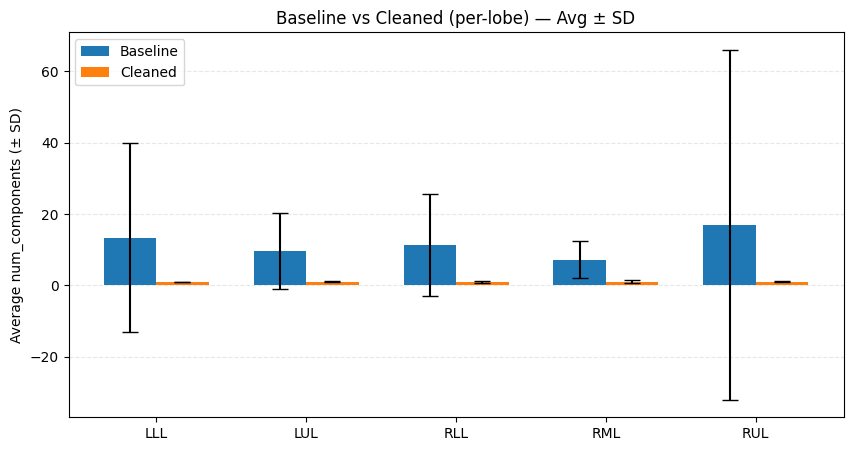

Saved bar plot with SD to: /content/drive/MyDrive/LOLA11/results/barplot_num_components_SD.png


In [19]:
# ================================================
# Cell 17 : Bar plot for num_components (avg ± SD per lobe)
# ================================================
import matplotlib.pyplot as plt
import numpy as np

# Compute standard deviation per lobe
std_base = merged.groupby("lobe_name")["num_components_base"].std()
std_clean = merged.groupby("lobe_name")["num_components_clean"].std()

labels = summary_lobe.index.tolist()
base_vals = summary_lobe["num_components_base"].tolist()
clean_vals = summary_lobe["num_components_clean"].tolist()

base_sd = std_base[labels].tolist()
clean_sd = std_clean[labels].tolist()

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,5))

# Bars with SD error bars
plt.bar(x - width/2, base_vals, width, yerr=base_sd, capsize=6, label='Baseline')
plt.bar(x + width/2, clean_vals, width, yerr=clean_sd, capsize=6, label='Cleaned')

plt.xticks(x, labels)
plt.ylabel("Average num_components (± SD)")
plt.title("Baseline vs Cleaned (per-lobe) — Avg ± SD")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

out_path = os.path.join(RESULT_DIR, "barplot_num_components_SD.png")
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()

print("Saved bar plot with SD to:", out_path)


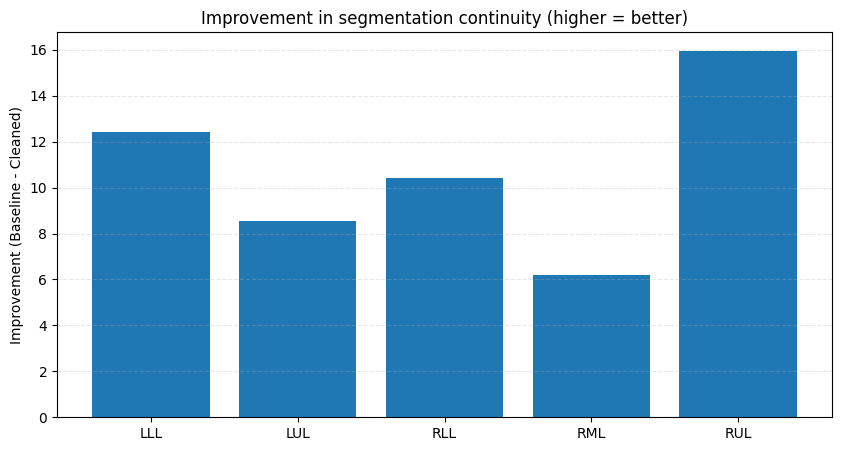

Saved improvement plot: /content/drive/MyDrive/LOLA11/results/barplot_improvement.png


In [18]:
# ================================================
# Cell 17 : Improvement bar chart
# ================================================
plt.figure(figsize=(10,5))
plt.bar(x, summary_lobe["delta_components"])
plt.xticks(x, labels)
plt.ylabel("Improvement (Baseline - Cleaned)")
plt.title("Improvement in segmentation continuity (higher = better)")
plt.grid(axis='y', linestyle='--', alpha=0.3)

out_path2 = os.path.join(RESULT_DIR, "barplot_improvement.png")
plt.savefig(out_path2, dpi=150, bbox_inches='tight')
plt.show()

print("Saved improvement plot:", out_path2)


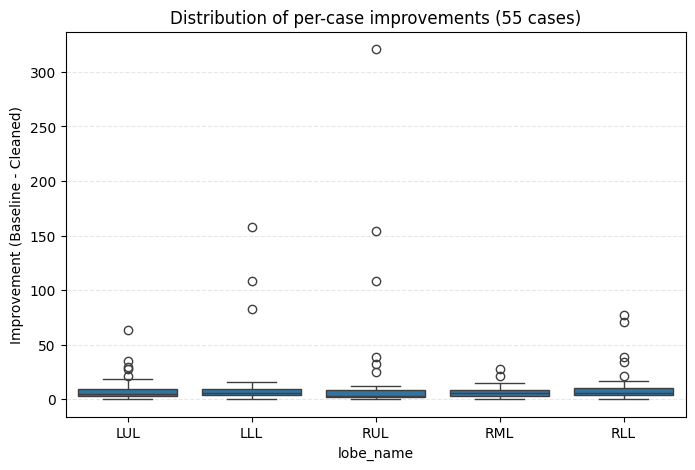

In [22]:
# ================================================
# Cell 18 : Per-case improvement boxplot
# ================================================
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x="lobe_name", y="delta_components")
plt.ylabel("Improvement (Baseline - Cleaned)")
plt.title("Distribution of per-case improvements (55 cases)")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


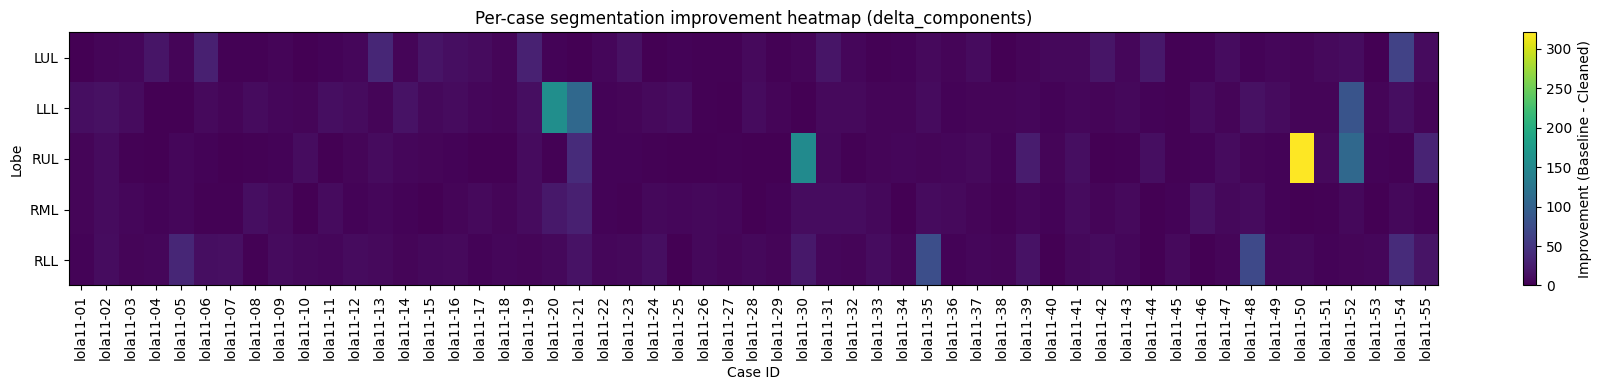

Saved heatmap to: /content/drive/MyDrive/LOLA11/results/heatmap_delta_components.png


In [23]:
# ================================================
# Cell 19 : Heatmap of per-case improvements
# ================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# We assume "merged" already exists from previous cells
# merged includes: case_id, lobe_name, num_components_base, num_components_clean

# Compute delta per row
merged["delta_components"] = (
    merged["num_components_base"] - merged["num_components_clean"]
)

# Get lists of unique lobes and case_ids in fixed order
lobes = ["LUL", "LLL", "RUL", "RML", "RLL"]
cases = sorted(merged["case_id"].unique())

# Create a matrix LOBE × CASE
heatmap_matrix = np.zeros((len(lobes), len(cases)))

for i, lobe in enumerate(lobes):
    for j, case in enumerate(cases):
        row = merged[(merged["lobe_name"] == lobe) & (merged["case_id"] == case)]
        if len(row) == 1:
            heatmap_matrix[i, j] = row["delta_components"].values[0]
        else:
            heatmap_matrix[i, j] = np.nan  # missing data

plt.figure(figsize=(18, 4))
plt.imshow(heatmap_matrix, cmap="viridis", aspect="auto")
plt.colorbar(label="Improvement (Baseline - Cleaned)")

plt.yticks(range(len(lobes)), lobes)
plt.xticks(range(len(cases)), cases, rotation=90)

plt.title("Per-case segmentation improvement heatmap (delta_components)")
plt.xlabel("Case ID")
plt.ylabel("Lobe")

plt.tight_layout()

out_path = os.path.join(RESULT_DIR, "heatmap_delta_components.png")
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved heatmap to:", out_path)
